# CCTA Dataset Creation: Ostia HU Attenuation Analysis

---

## 1. Create dataframes collecting the coronary ostia's world coordinates

In [ ]:
%cd ../

%config InlineBackend.figure_format = "retina"

/home/marco/thesis_project/contrast-gan-3D


In [ ]:
from itertools import chain
from pathlib import Path
from pprint import pprint
from typing import Dict, Iterable, Optional, Tuple, Union

import numpy as np
import pandas as pd
from batchgenerators.utilities.file_and_folder_operations import write_pickle
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV

from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.config import ROOT_DIR
from contrast_gan_3D.constants import DEFAULT_SEED, VMAX, VMIN
from contrast_gan_3D.data import utils as data_u
from contrast_gan_3D.eval import utils as eval_u
from contrast_gan_3D.utils import geometry as geom
from contrast_gan_3D.utils import io_utils, logging_utils
from contrast_gan_3D.utils import visualization as viz

logging_utils.set_project_loggers_level(level="INFO")

rng = np.random.default_rng()

contrast_gan_3D.utils.geometry: INFO -> INFO
contrast_gan_3D.utils.io_utils: INFO -> INFO
contrast_gan_3D.data.utils: INFO -> INFO
contrast_gan_3D.eval.CCTAContrastCorrector: INFO -> INFO
contrast_gan_3D.utils.visualization: INFO -> INFO
contrast_gan_3D.trainer.logger.LoggerInterface: INFO -> INFO


Adjust the variables in the following cell to match your setup. Run this code multiple times to process different datasets.

In [ ]:
DATASET_IDS = ["ASOCA_Philips", "MMWHS"]

PREPROC_DATA_DIR = Path("/home/marco/data/preproc")

DATASET_DIRS = [PREPROC_DATA_DIR / i for i in DATASET_IDS]

CENTERLINES_DIRS = [Path("/home/marco/data/auto_centerlines/") / i for i in DATASET_IDS]

OSTIA_DF_SAVENAMES = [dir / "ostia_world.xlsx" for dir in DATASET_DIRS]

pprint(DATASET_DIRS)
pprint(CENTERLINES_DIRS)
pprint(OSTIA_DF_SAVENAMES)

[PosixPath('/home/marco/data/preproc/ASOCA_Philips'),
 PosixPath('/home/marco/data/preproc/MMWHS')]
[PosixPath('/home/marco/data/auto_centerlines/ASOCA_Philips'),
 PosixPath('/home/marco/data/auto_centerlines/MMWHS')]
[PosixPath('/home/marco/data/preproc/ASOCA_Philips/ostia_world.xlsx'),
 PosixPath('/home/marco/data/preproc/MMWHS/ostia_world.xlsx')]


**The following cell might overwrite existing files!**

In [ ]:
if False:
    for centerlines_dir, ostia_df_savename in zip(CENTERLINES_DIRS, OSTIA_DF_SAVENAMES):
        print(f"Centerlines dir: {str(centerlines_dir)!r} Ostias file: {str(ostia_df_savename)!r}")

        ostia_paths = sorted(list(centerlines_dir.glob("*/ostia.xml")))

        ostia_dataframe = data_u.create_ostia_dataframe(
            ostia_paths, ostia_sheet_savename=ostia_df_savename
        )
        display(ostia_dataframe.head())

---

## 2. Divide the datapoints in optimal and suboptimal HU contrast values

CCTA scans are divided into *optimal* and *suboptimal* sets based on the contrast medium attenuation values at the 
aortic root. We fit a Mixture of Gaussians model on a 3D patch centered around the aortic root, and identify its 
attenuation value as the component with the highest mean HU value.

This data processing approach is described in 
"[Generative Adversarial Networks for Coronary CT Angiography Acquisition Protocol Correction with Explicit Attenuation Constraints (Van Herten, 2023)](https://openreview.net/pdf?id=MIHF_buWGUQ)"; the following code implementation is adapted from the first author's original codebase.

### 2.1. Create the ostia dataset

Adjust the variables in the following cell to match your setup:

In [ ]:
OSTIAS_COORDS_SAVEPATH = Path("/home/marco/data/ostia_world.xlsx")

pprint(list(zip(DATASET_IDS, OSTIA_DF_SAVENAMES)))
print(OSTIAS_COORDS_SAVEPATH)

[('ASOCA_Philips',
  PosixPath('/home/marco/data/preproc/ASOCA_Philips/ostia_world.xlsx')),
 ('MMWHS', PosixPath('/home/marco/data/preproc/MMWHS/ostia_world.xlsx'))]
/home/marco/data/ostia_world.xlsx


In [ ]:
if False:
    ostia_world_df = pd.concat(
        [
            pd.read_excel(path).assign(dataset=dataset_name)
            for path, dataset_name in zip(OSTIA_DF_SAVENAMES, DATASET_IDS)
        ]
    ).reset_index(drop=True)
    ostia_world_df.to_excel(OSTIAS_COORDS_SAVEPATH, index=False)
    print("Saved ostia dataset")
else:
    ostia_world_df = pd.read_excel(OSTIAS_COORDS_SAVEPATH)
    print("Loaded ostia dataset")

ostia_world_df

Loaded ostia dataset


,ID,x,y,z,dataset
0,ASOCA-000,212.899704,211.107513,-103.750000,ASOCA_Philips
1,ASOCA-000,219.139938,240.228622,-93.125000,ASOCA_Philips
2,ASOCA-001,177.677750,260.138702,-95.750000,ASOCA_Philips
3,ASOCA-001,189.806671,287.226593,-83.250000,ASOCA_Philips
4,ASOCA-002,189.720184,229.135803,-110.125000,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,-1.575071,-23.375074,-114.125000,MMWHS
236,ct_train_1019_image,-1.148491,-91.385208,-150.375000,MMWHS
237,ct_train_1019_image,18.871031,-68.436005,-141.625000,MMWHS
238,ct_train_1020_image,37.679688,96.350159,-178.280014,MMWHS


In [ ]:
# **** convert world coordinates dataframe to image ones (convenient for checking manually) ****
# NOTE for MMWHS dataset in ITK-SNAP coordinates are off

OSTIA_DATASET_IMG_COORDS_PATH = OSTIAS_COORDS_SAVEPATH.parent / "ostia_image.xlsx"

if False:
    ostia_img_df = ostia_world_df.copy()
    for dataset_folder in DATASET_DIRS:
        scan_paths = sorted(dataset_folder.glob("*.npy"))
        for path in scan_paths:
            patient_name = io_utils.stem(path)
            scan, meta = data_u.load_patient(path.parent / patient_name)
            offset, spacing = meta["offset"], meta["spacing"]

            indexer = [ostia_img_df["ID"] == patient_name, list("xyz")]
            coords = ostia_img_df.loc[*indexer].values

            img_coords = geom.world_to_image_coords(coords, offset, spacing)
            ostia_img_df.loc[*indexer] = img_coords

    ostia_img_df[list("xyz")] = ostia_img_df[list("xyz")].astype(int)

    ostia_img_df.to_excel(OSTIA_DATASET_IMG_COORDS_PATH, index=False)
    print(
        f"Saved ostia image coordinates dataset: {str(OSTIA_DATASET_IMG_COORDS_PATH)!r}"
    )
else:
    ostia_img_df = pd.read_excel(OSTIA_DATASET_IMG_COORDS_PATH)
    print(
        f"Loaded ostia image coordinates dataset: {str(OSTIA_DATASET_IMG_COORDS_PATH)!r}"
    )

ostia_img_df

Loaded ostia image coordinates dataset: '/home/marco/data/ostia_image.xlsx'


,ID,x,y,z,dataset
0,ASOCA-000,231,219,149,ASOCA_Philips
1,ASOCA-000,246,289,166,ASOCA_Philips
2,ASOCA-001,181,265,128,ASOCA_Philips
3,ASOCA-001,211,332,148,ASOCA_Philips
4,ASOCA-002,249,283,174,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,192,192,119,MMWHS
236,ct_train_1019_image,226,195,207,MMWHS
237,ct_train_1019_image,267,242,221,MMWHS
238,ct_train_1020_image,234,139,208,MMWHS


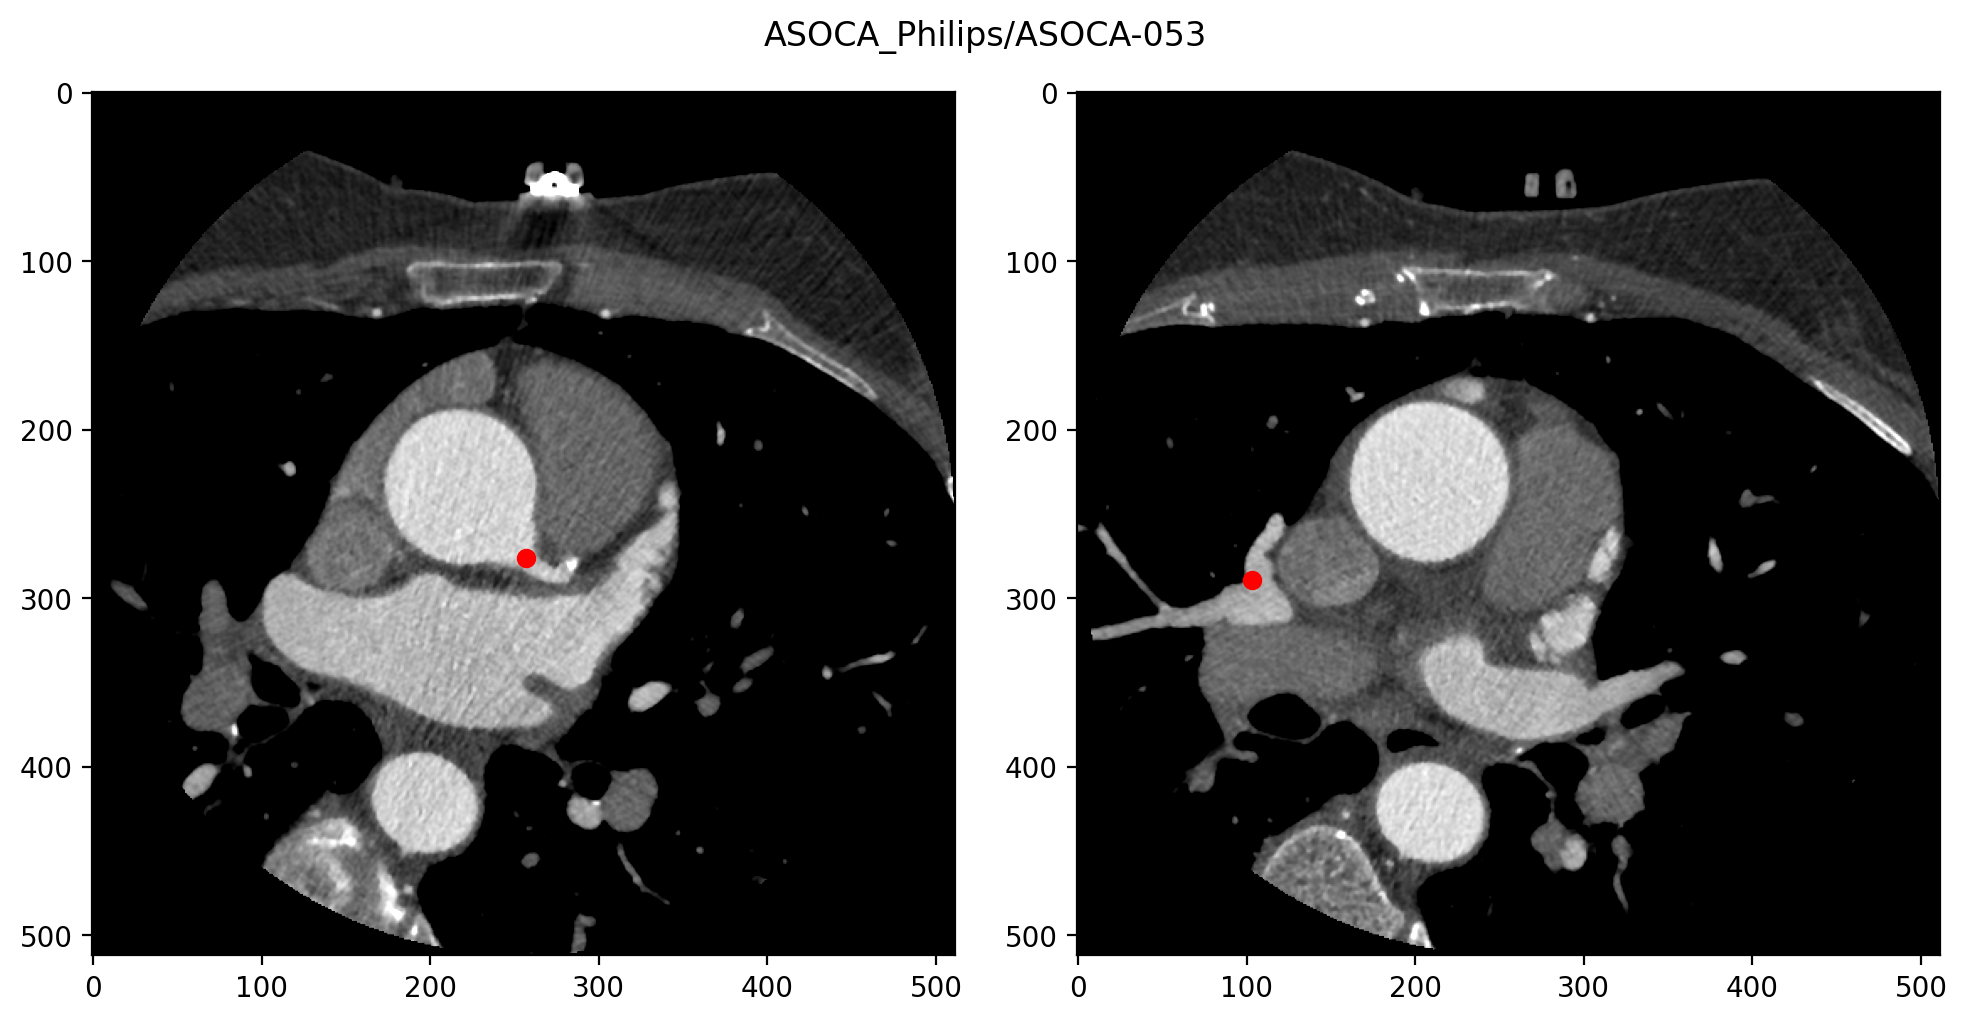

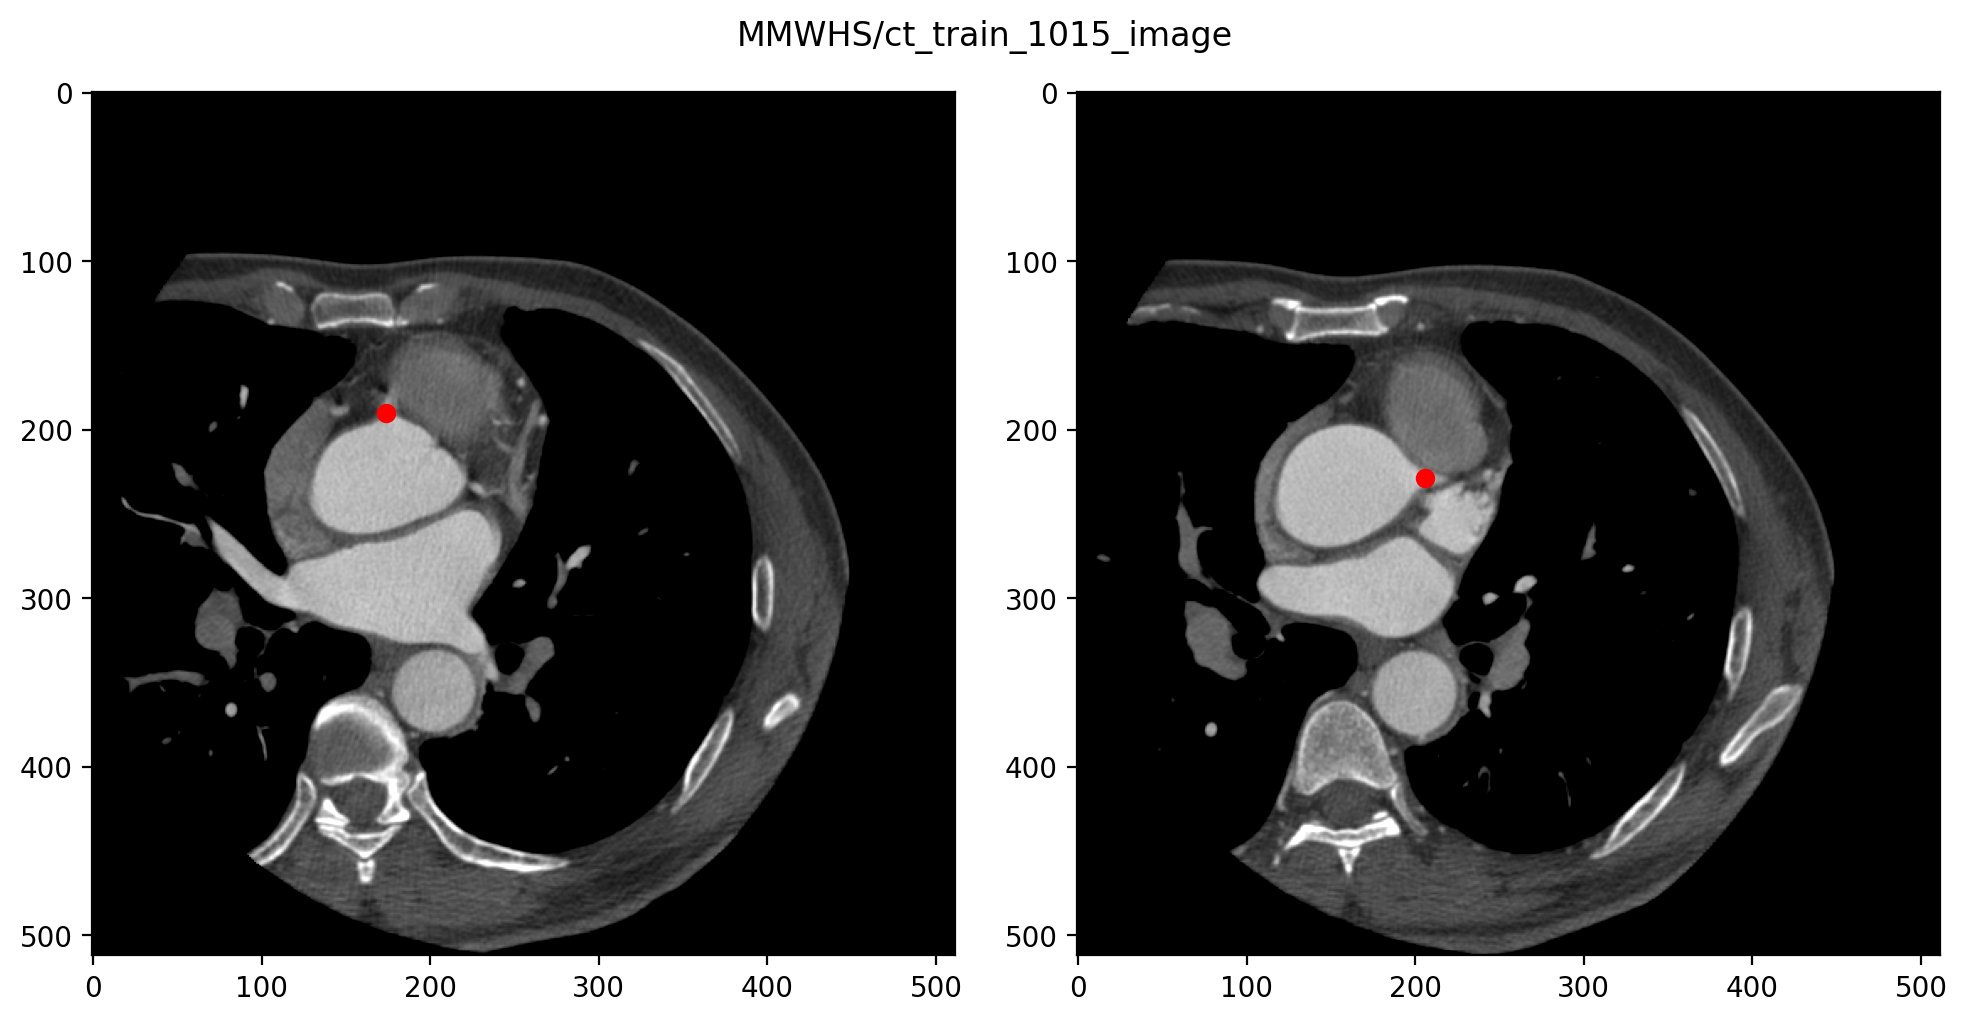

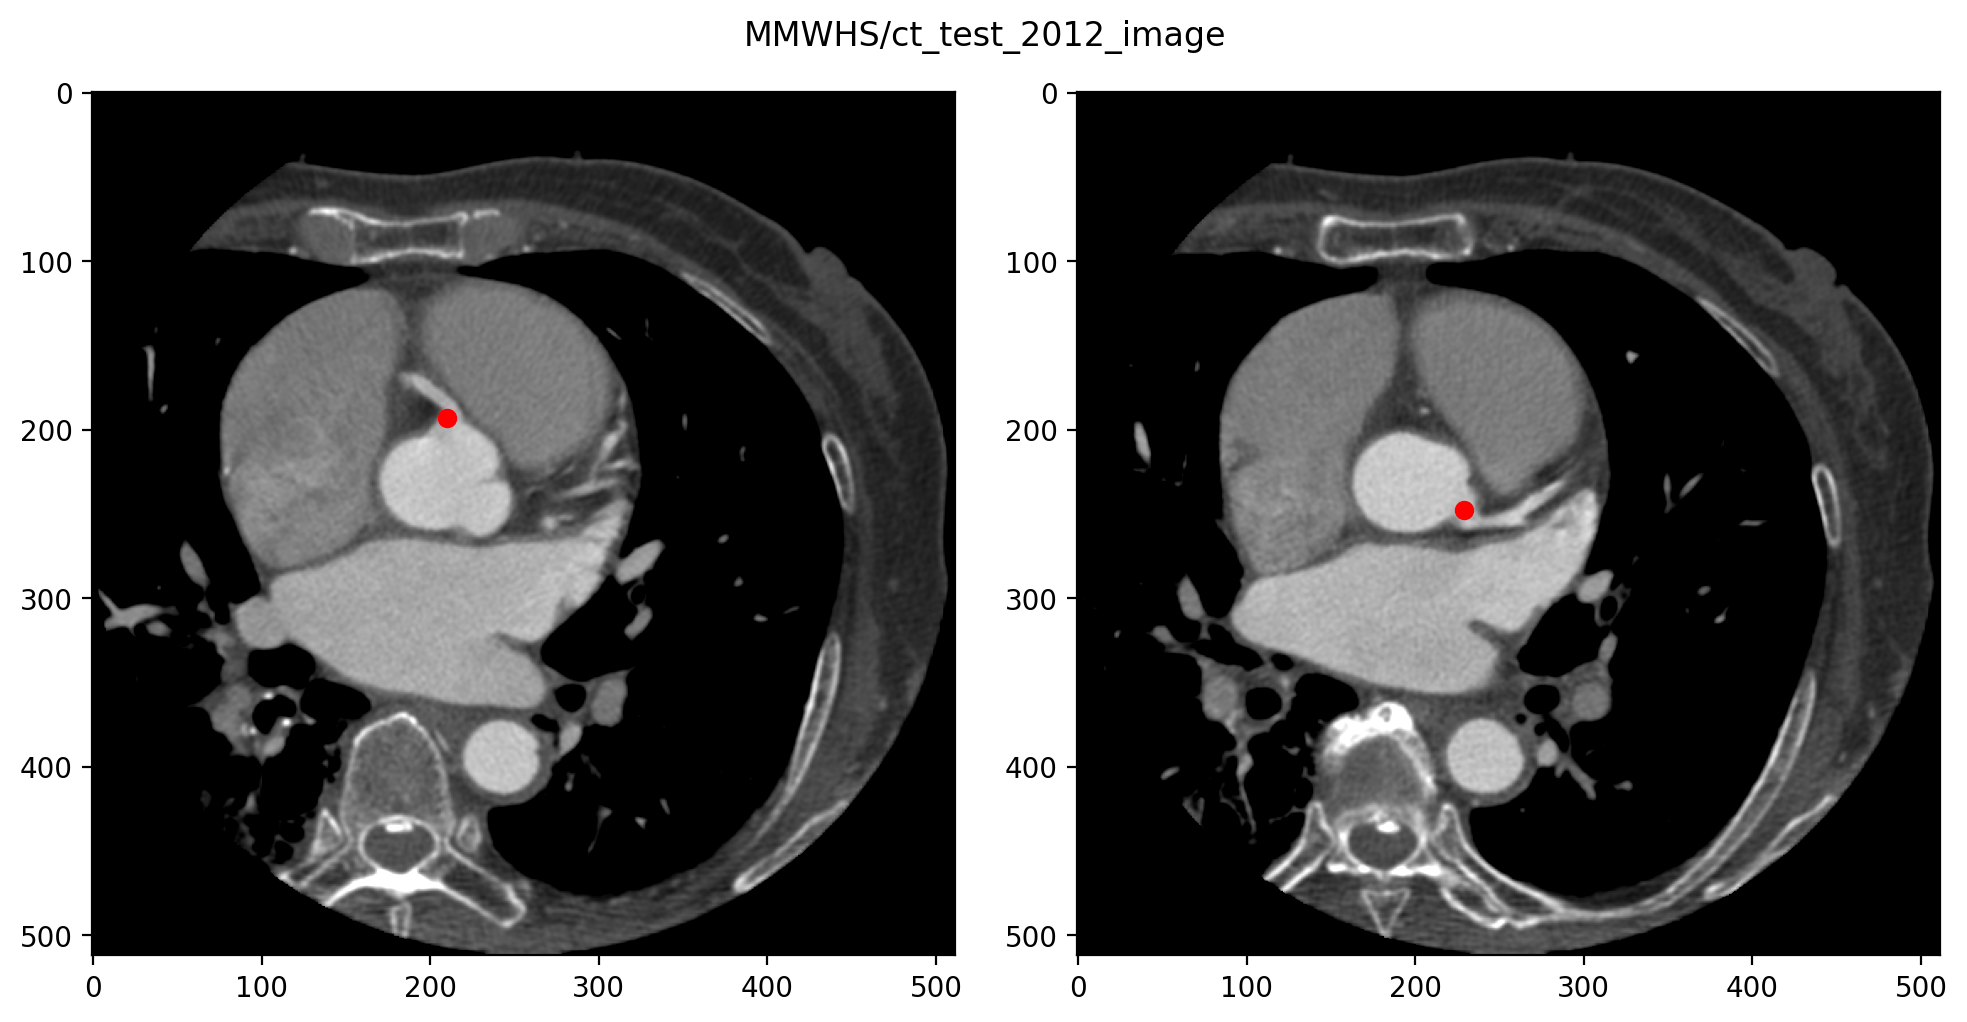

,ID,x,y,z,dataset
106,ASOCA-053,257,276,192,ASOCA_Philips
107,ASOCA-053,103,289,209,ASOCA_Philips
142,ct_test_2012_image,210,193,170,MMWHS
143,ct_test_2012_image,229,248,178,MMWHS
228,ct_train_1015_image,174,190,204,MMWHS
229,ct_train_1015_image,206,229,219,MMWHS


In [ ]:
# check that programmatically accessing ostias from the excel spreadsheet works correctly

RANDOM_SCANS = []

for tag in ["ASOCA", "ct_train", "ct_test"]:
    r = ostia_img_df.loc[ostia_img_df["ID"].str.contains(tag)].sample(1)
    dataset, id_ = r["dataset"].to_list()[0], r["ID"].to_list()[0]
    RANDOM_SCANS.append((id_, dataset))

    scan, _ = data_u.load_patient(PREPROC_DATA_DIR / dataset / id_)
    ostia_img = ostia_img_df.loc[
        ostia_img_df["ID"] == id_, list("xyz")
    ].values

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(scan[..., ostia_img[i, 2], 0].T, cmap="gray", vmin=VMIN, vmax=VMAX)
        ax.scatter(*ostia_img[i, :-1], c="red")

    fig.suptitle(f"{dataset}/{id_}")
    plt.tight_layout()
    plt.show()
    plt.close()

ostia_img_df.loc[ostia_img_df["ID"].isin([id_ for id_, _ in RANDOM_SCANS])]

---

### 2.2. Extract 3D patches around the ostia and plot some results

These patches are flattened and fitted with a Gaussian Mixture Model to identify the peak corresponding to the contrast
agent's HU intensity. First let's plot some of them to see what they look like.

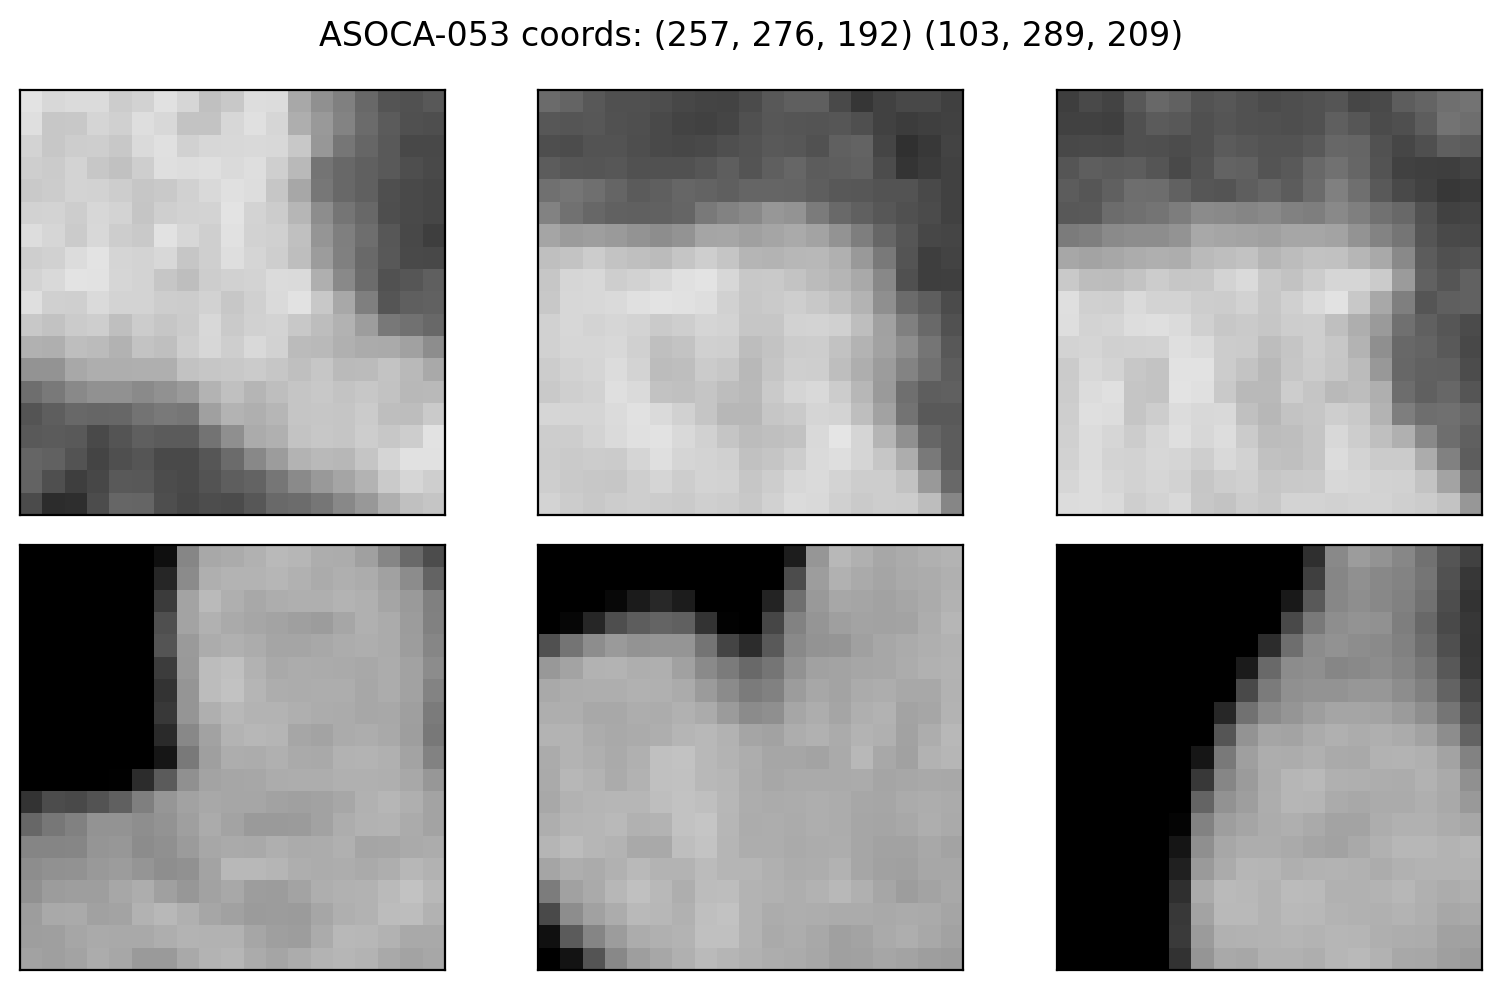

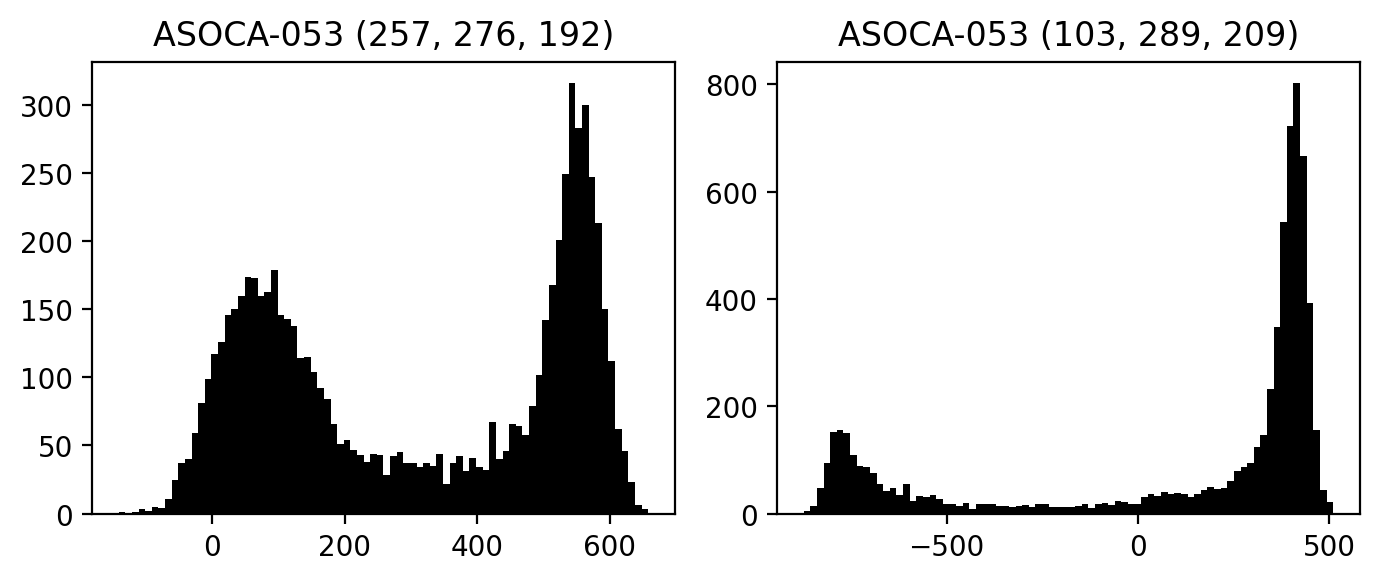

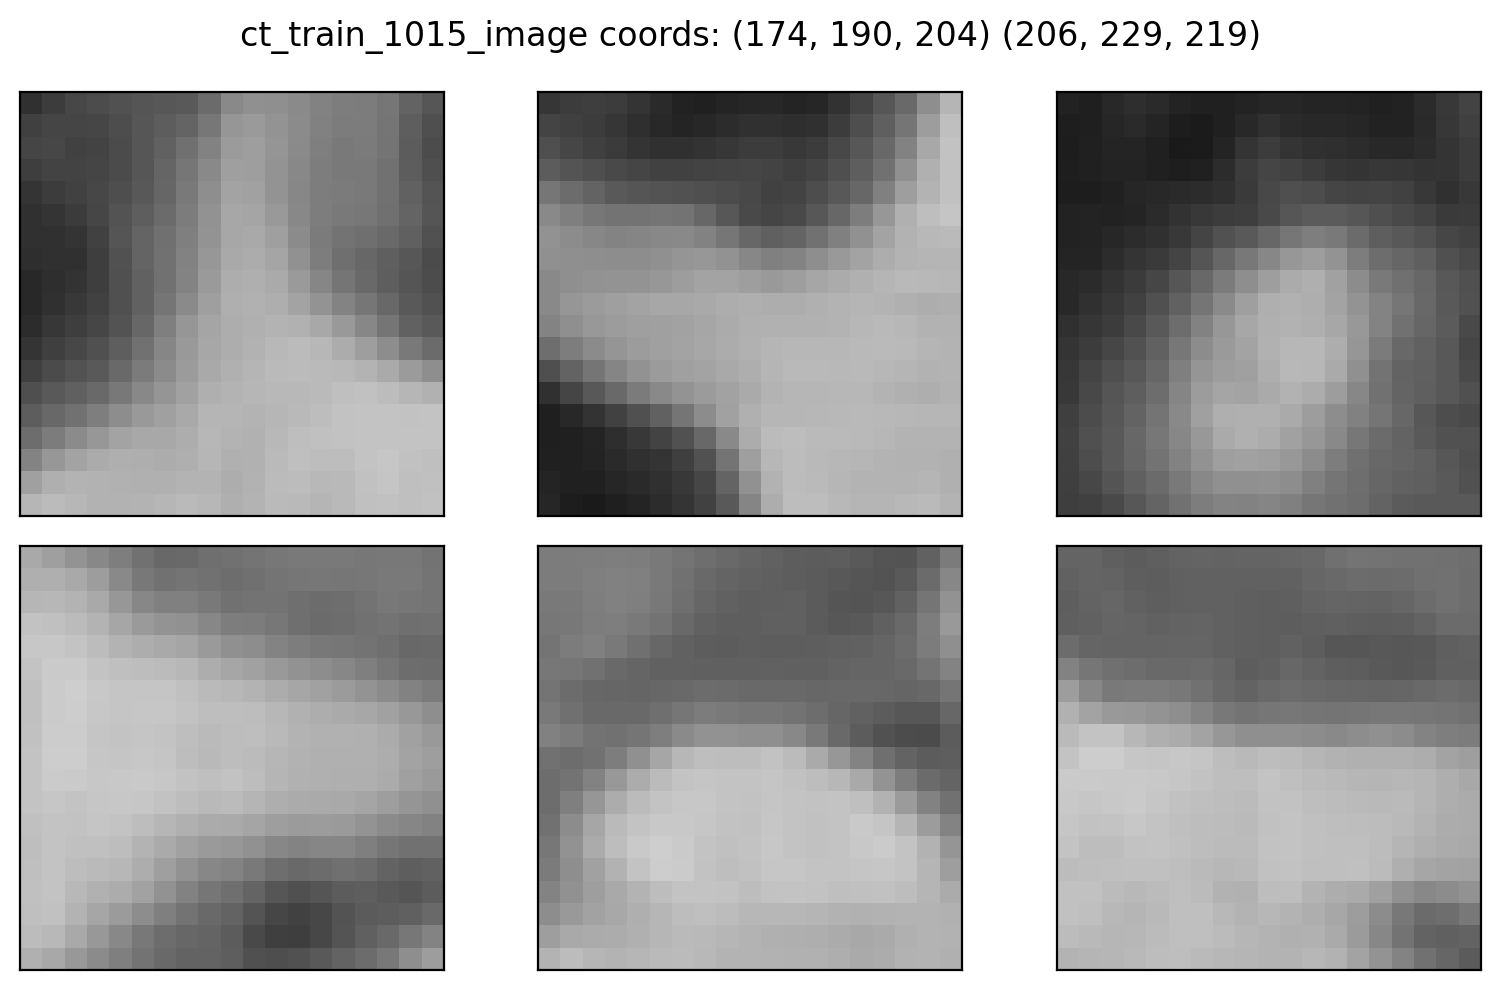

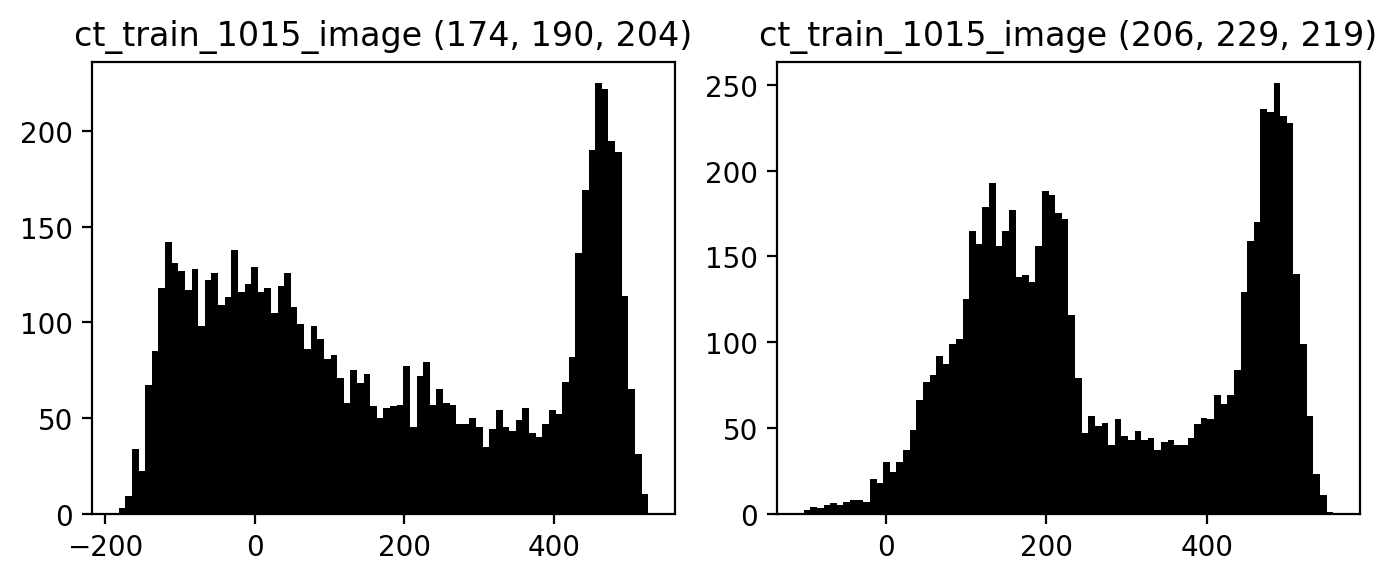

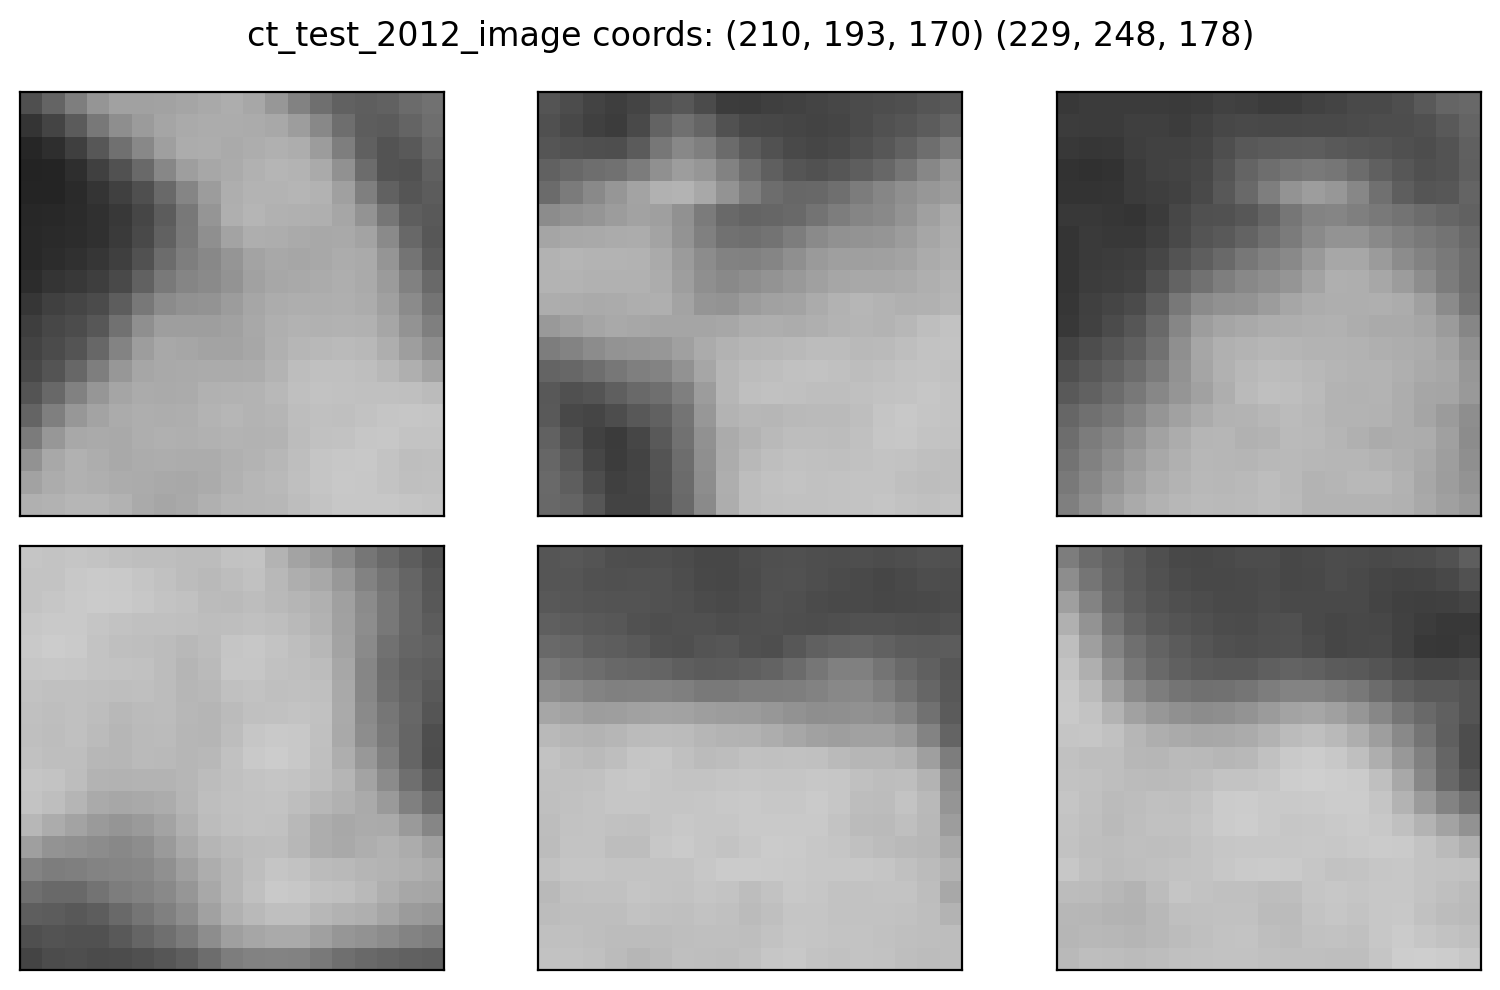

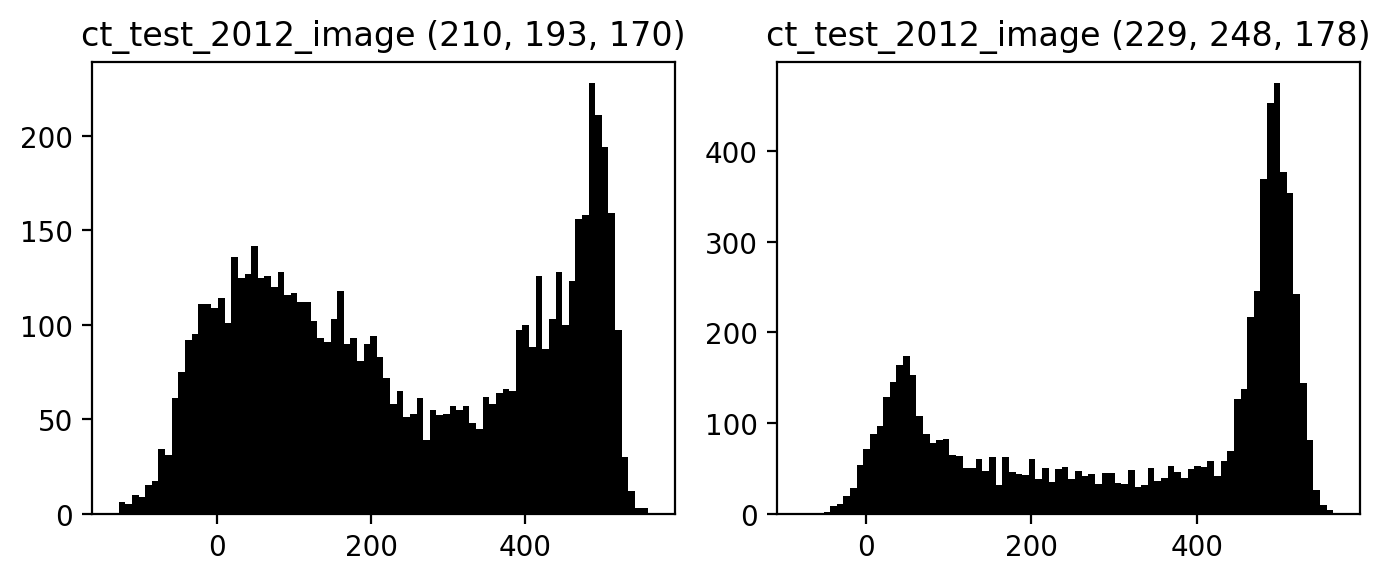

In [ ]:
SAVEDIR = None
# SAVEDIR = Path("/home/marco/contrast-gan-3D/assets/ostia-patches")
if SAVEDIR is not None:
    SAVEDIR.mkdir(parents=True, exist_ok=True)

for id_, dataset in RANDOM_SCANS:
    scan, meta = data_u.load_patient(PREPROC_DATA_DIR / dataset / id_)
    ostia_world = ostia_world_df.loc[ostia_world_df["ID"] == id_, list("xyz")].values

    ostia_patches = geom.extract_ostia_patch_3D(
        scan[..., 0], ostia_world, meta["offset"], meta["spacing"]
    )

    ostia_img = geom.world_to_image_coords(
        ostia_world, meta["offset"], meta["spacing"]
    )
    title_coords0, title_coords1 = list(map(tuple, ostia_img))

    fig, axes = plt.subplots(2, 3, figsize=(8, 5))
    for ostium, axes_row in zip(ostia_patches, axes):
        axes = viz.plot_ostium_patch(ostium, axes=axes_row)
    fig.suptitle(
        f"{id_} coords: {title_coords0} {title_coords1}",
    )
    plt.tight_layout()
    if SAVEDIR is None:
        plt.show()
    else:
        plt.savefig(SAVEDIR / f"{id_}_ostia_patches.png")
    plt.close(fig)

    z_middle = ostia_patches.shape[-1] // 2
    axes = viz.plot_image_histogram(
        (ostia_patches[0].ravel(), f"{id_} {title_coords0}"),
        (ostia_patches[1].ravel(), f"{id_} {title_coords1}"),
        tight=True,
        figsize=(7, 3),
    )
    plt.tight_layout()
    if SAVEDIR is None:
        plt.show()
    else:
        plt.savefig(SAVEDIR / f"{id_}_ostia_patches_hist.png")
    plt.close(axes[0, 0].get_figure())

---

### 2.3. Create a dataset of ostia mean HU values and standard deviation

In [ ]:
def GMM_grid_search(
    ostium_patch_1D: np.ndarray,
    max_n_components: int,
    max_iter: int = 1000,
    random_state: Optional[int] = None,
) -> GridSearchCV:
    return GridSearchCV(
        GMM(max_iter=max_iter, random_state=random_state, covariance_type="full"),
        param_grid={"n_components": range(1, max_n_components + 1)},
        scoring=lambda estimator, X: -estimator.bic(X),
    ).fit(ostium_patch_1D)


def pick_GMM_component(gmm: GMM) -> Tuple[Dict[str, float], pd.DataFrame]:
    mu, std = gmm.means_.squeeze(), np.sqrt(gmm.covariances_.squeeze())
    df = pd.DataFrame(
        np.stack([mu, std, gmm.weights_]).T, columns=["mu", "std", "weights"]
    ).sort_values(by="mu", ascending=False)
    return df.loc[df["std"] <= 150, df.columns != "weights"].iloc[0].to_dict(), df


def compute_ostia_HU_value(
    scan_path: Union[Path, str],
    savedir: Optional[Union[Path, str]],
    gmm_max_components: int,
    seed: Optional[int] = None,
    show: bool = True,
) -> Tuple[Dict[str, Union[float, str]], pd.DataFrame, np.ndarray]:
    if savedir is not None:
        savedir = Path(savedir)
        savedir.mkdir(parents=True, exist_ok=True)

    name = io_utils.stem(scan_path)
    scan, meta = data_u.load_patient(Path(scan_path).parent / name)
    offset, spacing, ostia_world = meta["offset"], meta["spacing"], meta["ostia_world"]

    # 1. Sample the ostia patches
    ostia_patches = geom.extract_ostia_patch_3D(
        scan[..., 0], ostia_world, offset, spacing
    )
    res = []
    for ostium in ostia_patches.reshape(2, -1, 1):
        # 2. Fit a GMM with hyperparams sweep on the flat patches' intensities
        grid_search = GMM_grid_search(ostium, gmm_max_components, random_state=seed)
        gmm = grid_search.best_estimator_
        print("Optimal # components:", gmm.n_components)
        # 3. Select the Gaussian component with reasonable std and highest mean HU values
        hu_peak, df = pick_GMM_component(gmm)
        res.append(({"ID": name} | hu_peak, df))
        display(df)
        # print(res[-1][0])

    # **** Plotting ****
    ostia_img = geom.world_to_image_coords(ostia_world, offset, spacing)
    title_coords0, title_coords1 = list(map(tuple, ostia_img))

    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    viz.plot_image_histogram(
        (ostia_patches[0].ravel(), str(title_coords0)),
        (ostia_patches[1].ravel(), str(title_coords1)),
        figsize=(6, 4),
        axes=axes[:, 0],
    )
    for ostium_patch, axes_row, (hu_peak, df) in zip(ostia_patches, axes, res):
        viz.plot_GMM_fitted_ostium_patch(
            ostium_patch,
            *df.values.T[..., None],
            gmm_max_components,
            axes=axes_row[1:],
            title=f"N: {len(df)} mu: {hu_peak['mu']:.2f} std: {hu_peak['std']:.2f}",
        )
    fig.suptitle(f"{name}, columns 1-4: Z middle, 5: full 3D patch")
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(savedir / f"{name}_ostia_HU.png")
    if show:
        plt.show()
    plt.close(fig)

    return *zip(*res), axes

Adjust the variables in the following cell to match your setup:

In [ ]:
HU_DF_FNAME = Path("/home/marco/data/ostia_HU.xlsx")

PLOTS_SAVEDIR = ROOT_DIR / "assets/ostia_HU_GMM/"

SEED = DEFAULT_SEED

GMM_N_MIXTURES = 6

scan_paths = sorted(chain(*[list(d.glob("*.npy")) for d in DATASET_DIRS]))

print(len(scan_paths), scan_paths[0])
print(HU_DF_FNAME)
print(PLOTS_SAVEDIR)
print(GMM_N_MIXTURES)

ostia_world_df

120 /home/marco/data/preproc/ASOCA_Philips/ASOCA-000.npy
/home/marco/data/ostia_HU.xlsx
/home/marco/thesis_project/contrast-gan-3D/assets/ostia_HU_GMM
6


,ID,x,y,z,dataset
0,ASOCA-000,212.899704,211.107513,-103.750000,ASOCA_Philips
1,ASOCA-000,219.139938,240.228622,-93.125000,ASOCA_Philips
2,ASOCA-001,177.677750,260.138702,-95.750000,ASOCA_Philips
3,ASOCA-001,189.806671,287.226593,-83.250000,ASOCA_Philips
4,ASOCA-002,189.720184,229.135803,-110.125000,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,-1.575071,-23.375074,-114.125000,MMWHS
236,ct_train_1019_image,-1.148491,-91.385208,-150.375000,MMWHS
237,ct_train_1019_image,18.871031,-68.436005,-141.625000,MMWHS
238,ct_train_1020_image,37.679688,96.350159,-178.280014,MMWHS


Optimal # components: 3


,mu,std,weights
2,548.000554,38.599238,0.400784
0,327.285137,110.269323,0.177138
1,73.485980,64.507392,0.422078


Optimal # components: 6


,mu,std,weights
4,408.914333,32.778285,0.546933
1,299.900728,60.367279,0.127062
3,77.241390,94.712613,0.074599
2,-265.896193,122.402599,0.042712
0,-586.894413,81.266628,0.065131
5,-760.359479,44.698983,0.143562


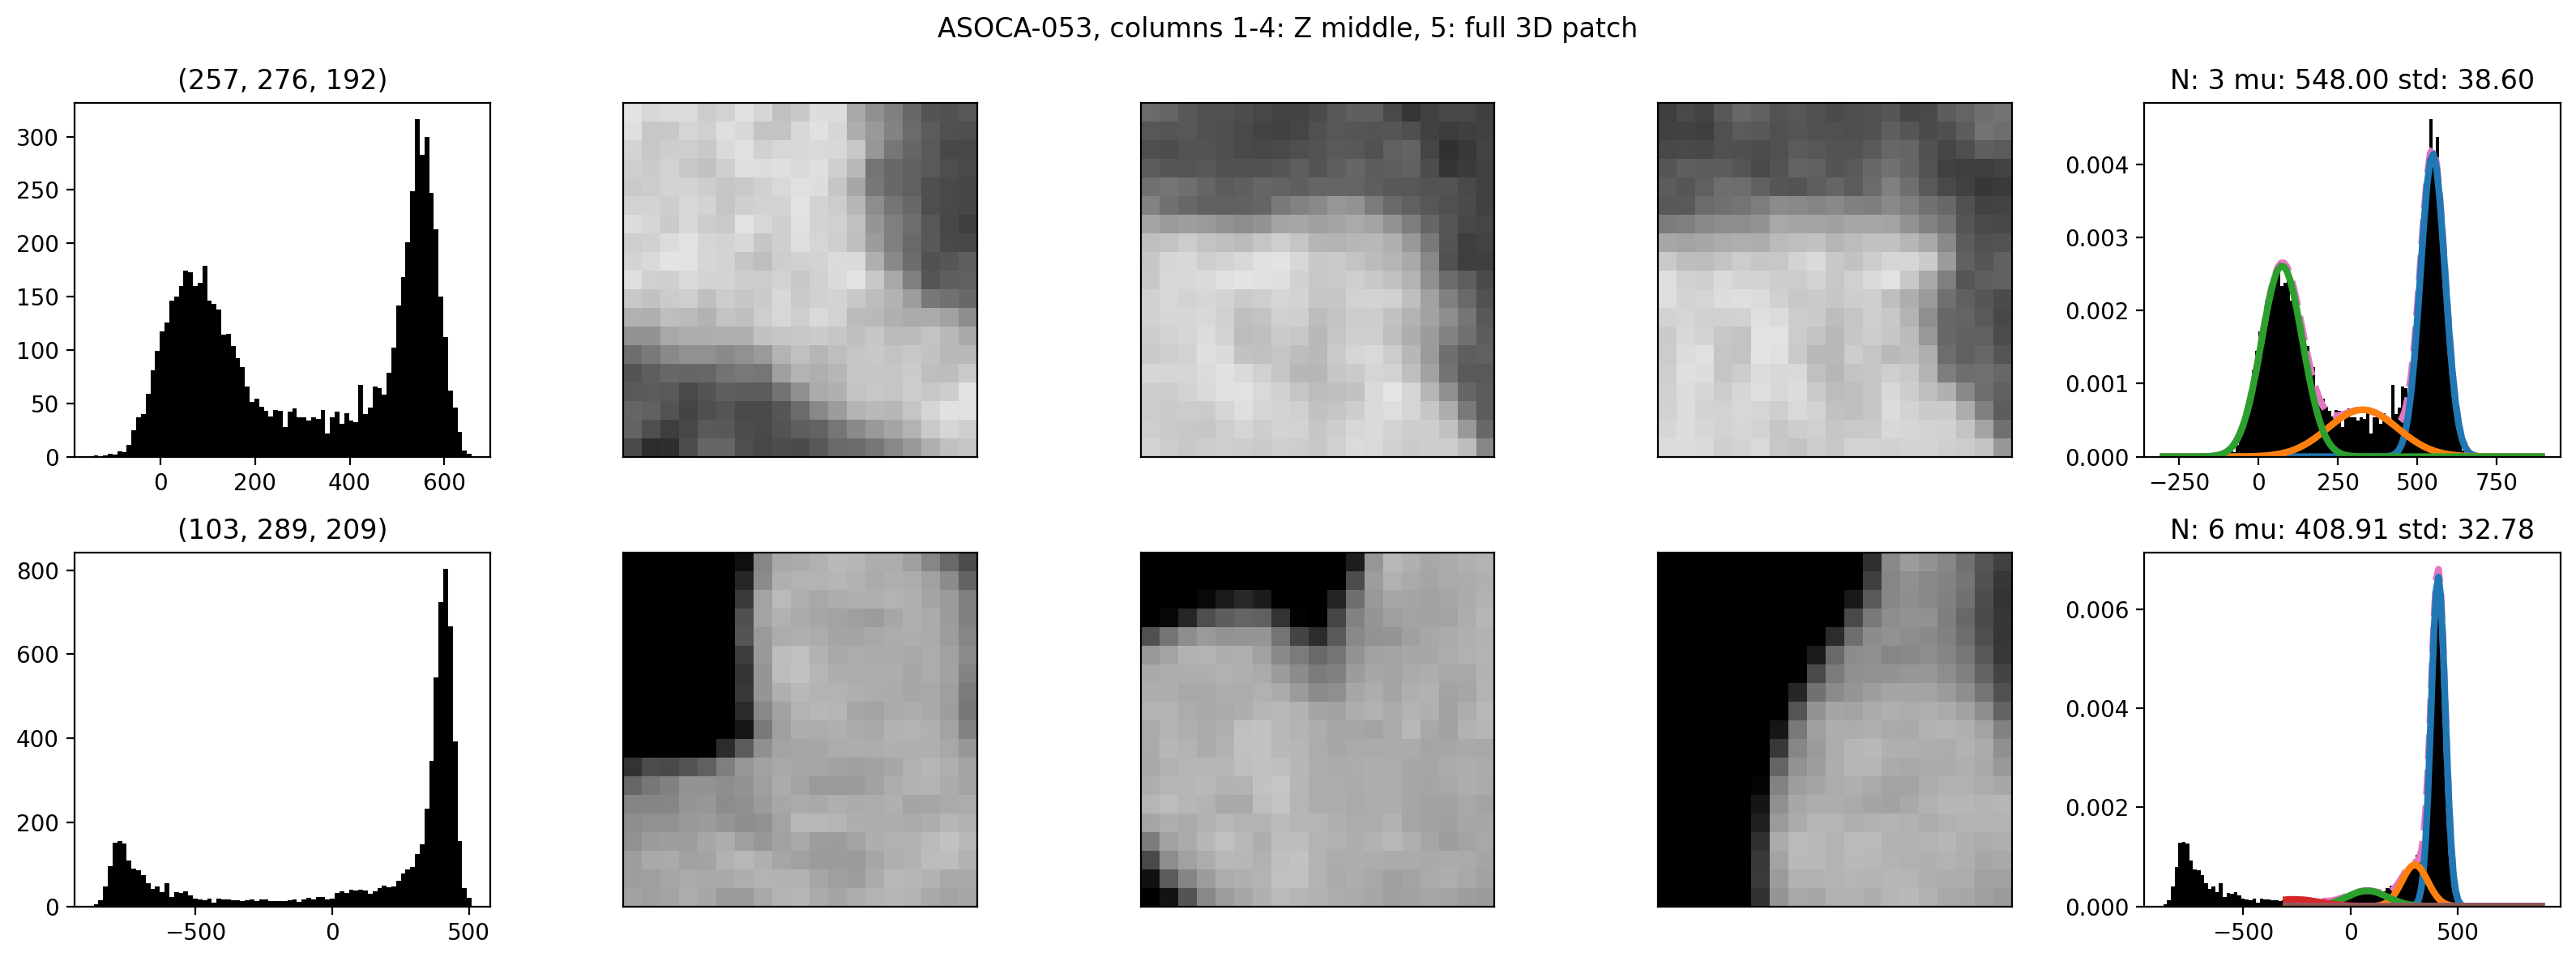

Optimal # components: 4


,mu,std,weights
1,460.089927,26.761921,0.249232
2,261.633644,90.319258,0.239276
3,48.937651,59.910443,0.266489
0,-79.513618,43.938524,0.245003


Optimal # components: 2


,mu,std,weights
1,471.246344,37.010566,0.355552
0,168.654195,89.492090,0.644448


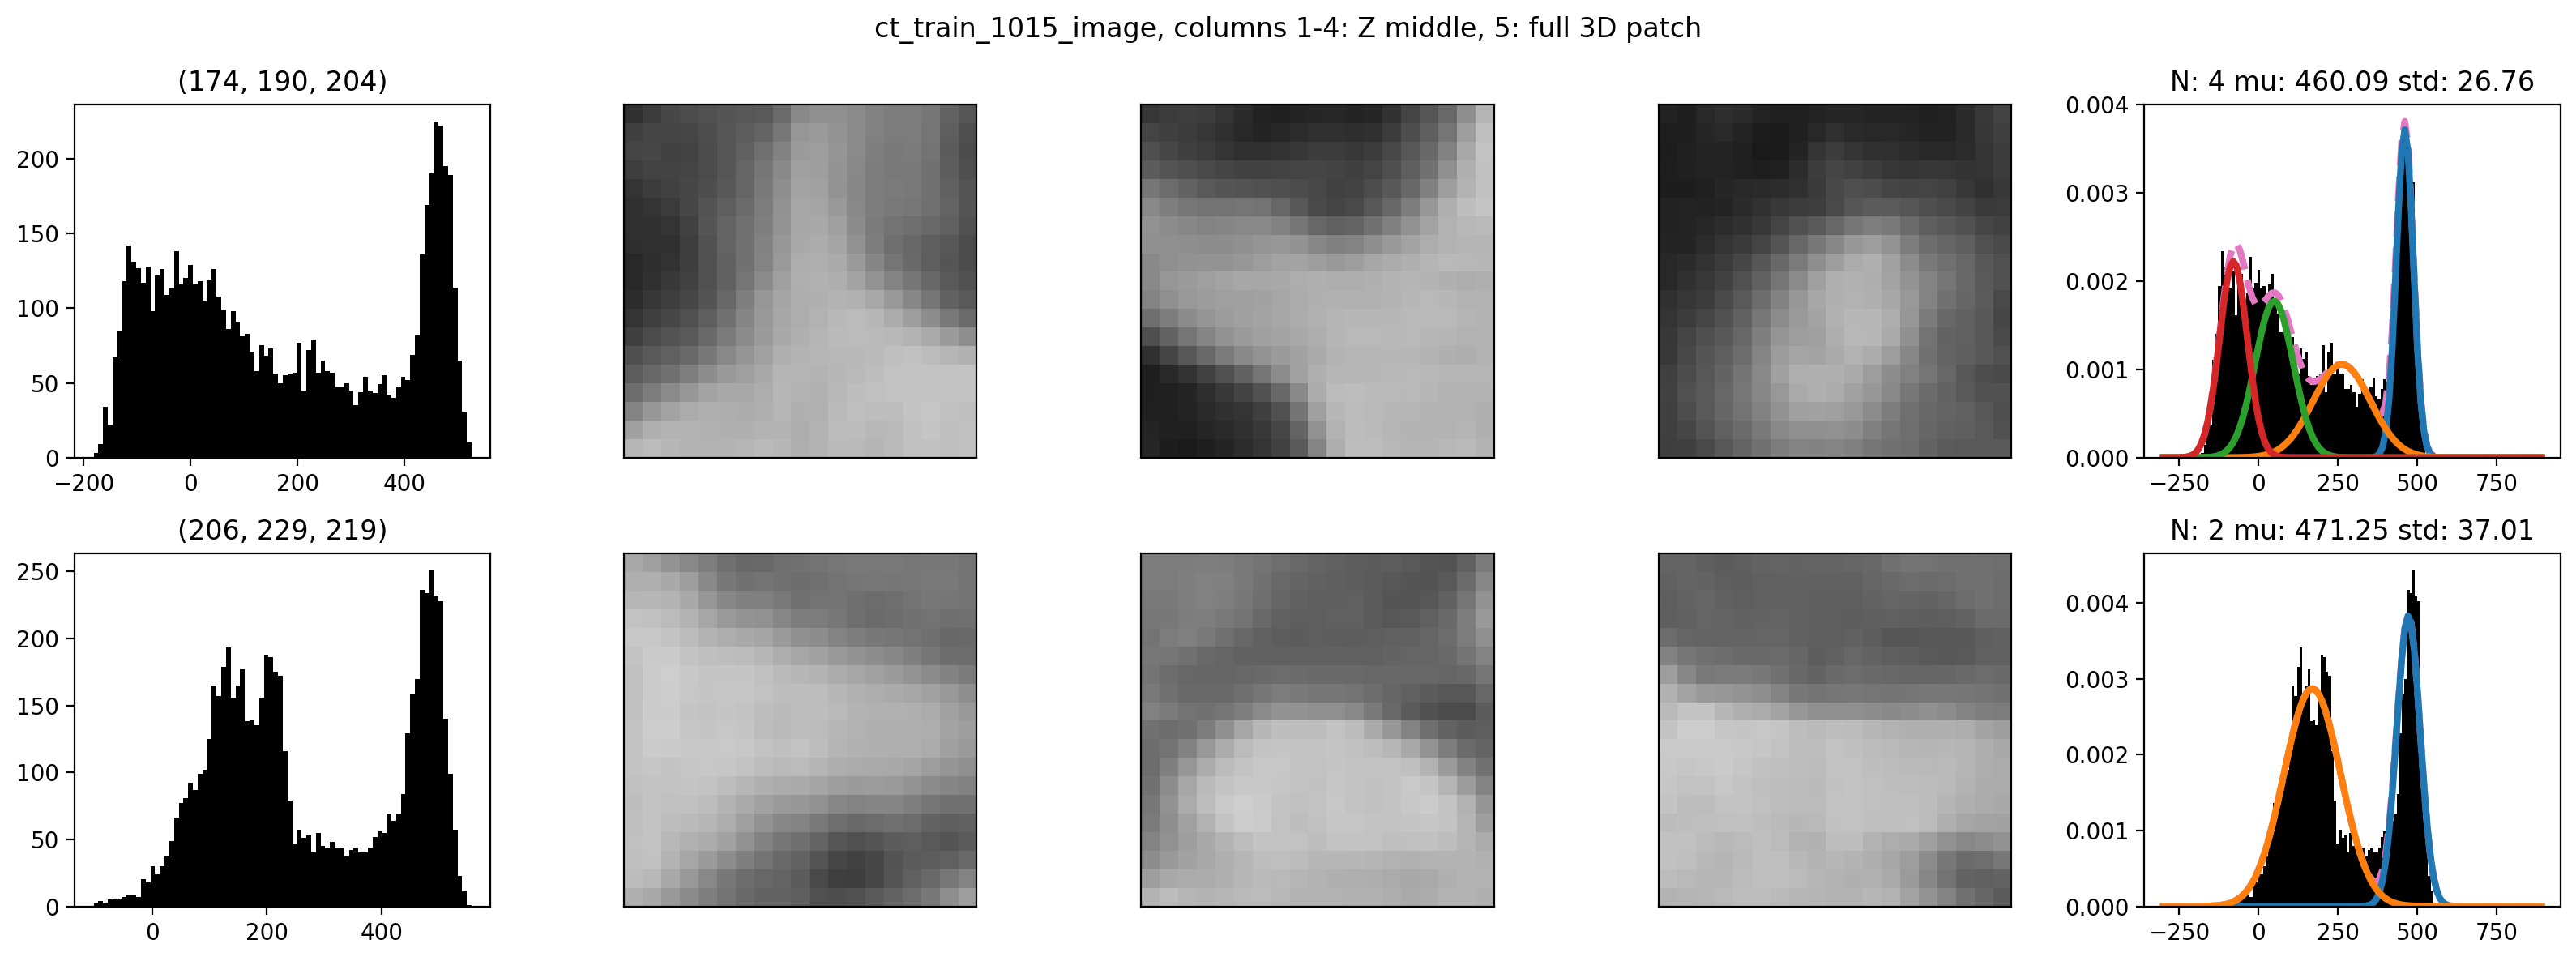

Optimal # components: 3


,mu,std,weights
1,456.111462,48.655137,0.352903
0,210.802666,87.909712,0.299034
2,34.984171,62.532180,0.348063


Optimal # components: 4


,mu,std,weights
0,493.470111,23.291985,0.474015
3,371.445233,58.978439,0.134427
2,194.510108,59.248540,0.145610
1,48.509951,36.698038,0.245947


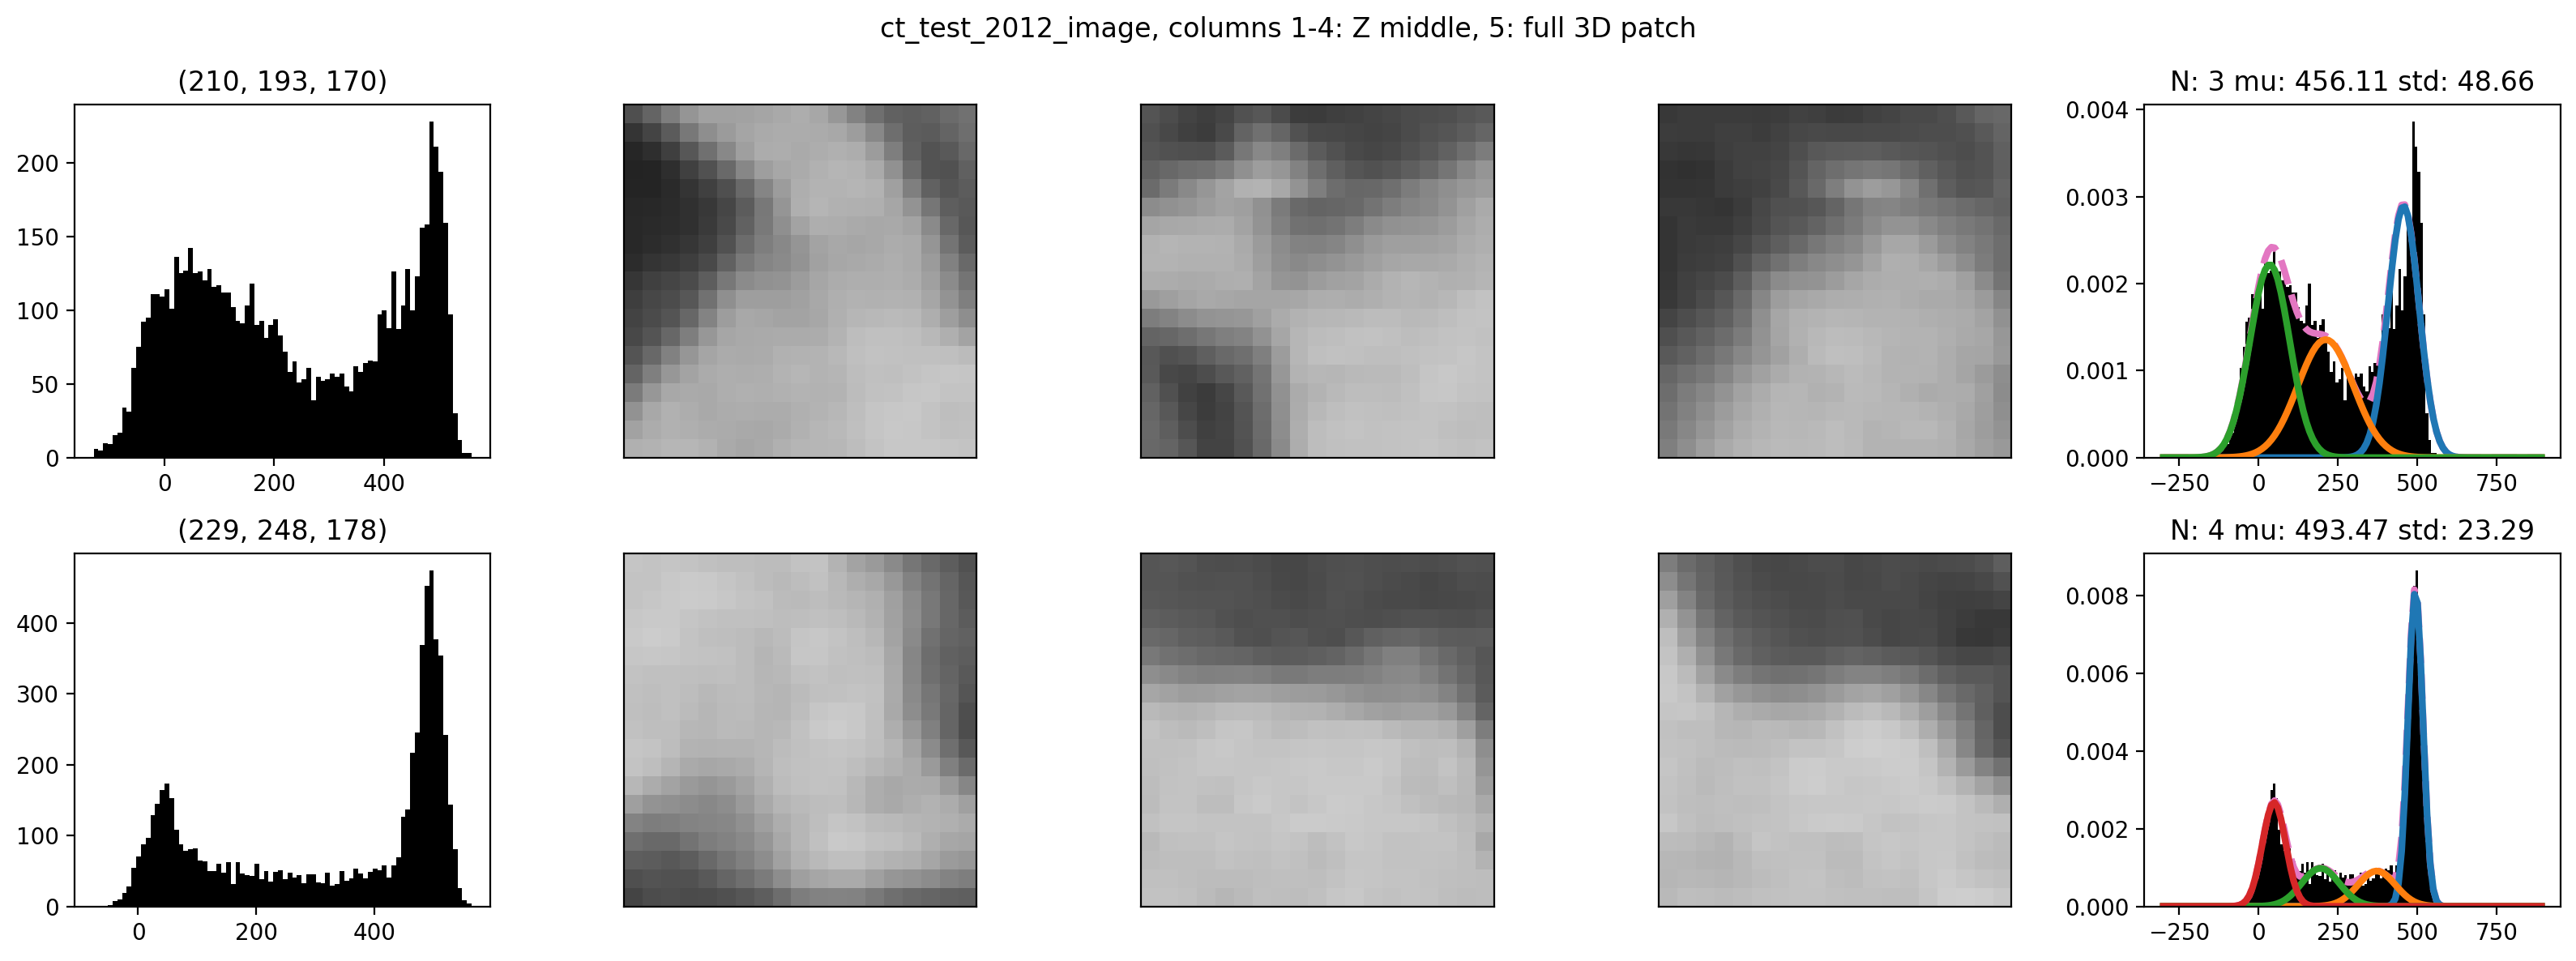

In [ ]:
# check that things make sense

for id_, dataset in RANDOM_SCANS:
    scan_path = PREPROC_DATA_DIR / dataset / id_
    a = compute_ostia_HU_value(scan_path, None, GMM_N_MIXTURES)

**The following cell might overwrite existing files!**

In [ ]:
# TODO parallelize

# %%time

if False:
    ostia_HU_df = []
    for s in scan_paths:
        print(s)
        hu_peaks, *_ = compute_ostia_HU_value(
            s,
            PLOTS_SAVEDIR,
            GMM_N_MIXTURES,
            seed=SEED,
            show=False,
        )
        print("---")
        ostia_HU_df += hu_peaks

    ostia_HU_df = pd.DataFrame(ostia_HU_df)
    ostia_HU_df.to_excel(HU_DF_FNAME, index=False)
    print(f"Saved HU dataframe to '{HU_DF_FNAME}'")
    ostia_HU_df

In [ ]:
ostia_HU_df = pd.read_excel(HU_DF_FNAME)
print("Loaded ostia HU mean and std")
ostia_HU_df

Loaded ostia HU mean and std


,ID,mu,std
0,ASOCA-000,411.801545,38.914087
1,ASOCA-000,417.637377,39.911285
2,ASOCA-001,471.351123,38.684994
3,ASOCA-001,482.516019,29.968211
4,ASOCA-002,544.765628,29.733012
...,...,...,...
235,ct_train_1018_image,566.599794,110.788253
236,ct_train_1019_image,262.567222,39.186438
237,ct_train_1019_image,274.989892,76.035294
238,ct_train_1020_image,473.588226,108.706747


---

### 3. Create a final dataframe with all the extracted information and datapoints labels 

In [ ]:
def join_dfs(*dfs) -> pd.DataFrame:
    out = pd.concat(
        [df.sort_values(by="ID").reset_index(drop=True) for df in dfs], axis=1
    )
    return out.loc[:, ~out.columns.duplicated()].copy()


def add_paths(df: pd.DataFrame, paths: Iterable[Union[Path, str]]) -> pd.DataFrame:
    df = df.copy()
    assert len(df) == len(paths)
    paths = [Path(p).parent / io_utils.stem(p) for p in paths]
    for i, p in enumerate(paths):
        assert df.iloc[i]["ID"] == io_utils.stem(p)
    df["path"] = paths
    return df

In [ ]:
# add information on HU attenuation difference within the same scan
TMP = ostia_HU_df.copy()
g = TMP.groupby("ID")
TMP["mu_diff"] = g["mu"].diff()
TMP["std_diff"] = g["std"].diff()
TMP

,ID,mu,std,mu_diff,std_diff
0,ASOCA-000,411.801545,38.914087,NaN,NaN
1,ASOCA-000,417.637377,39.911285,5.835832,0.997198
2,ASOCA-001,471.351123,38.684994,NaN,NaN
3,ASOCA-001,482.516019,29.968211,11.164896,-8.716784
4,ASOCA-002,544.765628,29.733012,NaN,NaN
...,...,...,...,...,...
235,ct_train_1018_image,566.599794,110.788253,15.630795,66.265665
236,ct_train_1019_image,262.567222,39.186438,NaN,NaN
237,ct_train_1019_image,274.989892,76.035294,12.422670,36.848856
238,ct_train_1020_image,473.588226,108.706747,NaN,NaN


In [ ]:
for col_name in ["mu_diff", "std_diff"]:
    TMP.loc[TMP[col_name].isna(), col_name] = -TMP.loc[
        TMP[col_name].notna(), col_name
    ].values

In [ ]:
FINAL_DF_FNAME = Path("/home/marco/data/ostia_final.xlsx")
FINAL_DF_IMG_FNAME = FINAL_DF_FNAME.parent / (
    io_utils.stem(FINAL_DF_FNAME) + "_image.xlsx"
)

if False:
    for df, savepath in zip(
        [ostia_world_df, ostia_img_df], [FINAL_DF_FNAME, FINAL_DF_IMG_FNAME]
    ):
        final_df = data_u.label_ccta_scan(join_dfs(df, ostia_HU_df))
        for col_name in ["mu_diff", "std_diff"]:
            final_df[col_name] = TMP.loc[final_df.index, col_name]
        final_df = add_paths(final_df, scan_paths)
        final_df.to_excel(savepath, index=False)
        print(f"Saved final ostia dataframe to {str(savepath)!r}")

final_df_img = pd.read_excel(FINAL_DF_IMG_FNAME)
print(f"Loaded final ostia dataframe from {str(FINAL_DF_IMG_FNAME)!r}")

# display(final_df_img)

print()
for lab in sorted(final_df_img["label"].unique()):
    lab_cases = len(final_df_img.loc[final_df_img["label"] == lab])
    lab_fraction = lab_cases / len(final_df_img)
    print(f"Label {lab}: {lab_fraction:.3f} ({lab_cases} ostia)")

print("\nBreakdown by dataset:")
for dataset in final_df_img["dataset"].unique():
    for lab in sorted(final_df_img["label"].unique()):
        subs = final_df_img.loc[
            (final_df_img["dataset"] == dataset) & (final_df_img["label"] == lab), :
        ]
        print(dataset, "label", lab, "len", len(subs))
        display(subs[:10])
# final_df_img[["ID", "dataset", "label"]].groupby(["dataset", "label"]).count()

Loaded final ostia dataframe from '/home/marco/data/ostia_final_image.xlsx'

Label -1: 0.083 (10 ostia)
Label 0: 0.558 (67 ostia)
Label 1: 0.358 (43 ostia)

Breakdown by dataset:
ASOCA_Philips label -1 len 6


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
29,ASOCA-029,244,272,192,ASOCA_Philips,273.977105,30.461825,-1,-10.740777,3.310608,/home/marco/data/preproc/ASOCA_Philips/ASOCA-029
30,ASOCA-030,219,276,177,ASOCA_Philips,285.105477,27.802981,-1,10.310198,-3.968555,/home/marco/data/preproc/ASOCA_Philips/ASOCA-030
34,ASOCA-034,225,352,185,ASOCA_Philips,285.912147,25.864995,-1,30.815044,-3.861701,/home/marco/data/preproc/ASOCA_Philips/ASOCA-034
47,ASOCA-047,235,255,168,ASOCA_Philips,280.895817,24.402901,-1,41.287199,-11.567536,/home/marco/data/preproc/ASOCA_Philips/ASOCA-047
52,ASOCA-052,189,229,156,ASOCA_Philips,278.077412,39.680528,-1,-72.930138,-8.912033,/home/marco/data/preproc/ASOCA_Philips/ASOCA-052
59,ASOCA-059,240,215,141,ASOCA_Philips,290.697866,51.031800,-1,-29.324274,3.160728,/home/marco/data/preproc/ASOCA_Philips/ASOCA-059


ASOCA_Philips label 0 len 31


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
0,ASOCA-000,231,219,149,ASOCA_Philips,411.801545,38.914087,0,-5.835832,-0.997198,/home/marco/data/preproc/ASOCA_Philips/ASOCA-000
1,ASOCA-001,211,332,148,ASOCA_Philips,482.516019,29.968211,0,11.164896,-8.716784,/home/marco/data/preproc/ASOCA_Philips/ASOCA-001
5,ASOCA-005,257,285,177,ASOCA_Philips,499.879015,35.677081,0,32.381517,-13.421184,/home/marco/data/preproc/ASOCA_Philips/ASOCA-005
7,ASOCA-007,265,240,188,ASOCA_Philips,433.869466,35.707495,0,101.909490,-12.563902,/home/marco/data/preproc/ASOCA_Philips/ASOCA-007
8,ASOCA-008,214,225,187,ASOCA_Philips,460.968413,33.036155,0,-0.947585,-0.200803,/home/marco/data/preproc/ASOCA_Philips/ASOCA-008
9,ASOCA-009,221,265,179,ASOCA_Philips,431.659979,33.071831,0,-2.622362,-8.808979,/home/marco/data/preproc/ASOCA_Philips/ASOCA-009
14,ASOCA-014,253,281,172,ASOCA_Philips,494.713668,27.925255,0,16.307945,8.979466,/home/marco/data/preproc/ASOCA_Philips/ASOCA-014
18,ASOCA-018,245,303,202,ASOCA_Philips,354.409929,28.734544,0,-2.200921,-2.667811,/home/marco/data/preproc/ASOCA_Philips/ASOCA-018
19,ASOCA-019,267,270,200,ASOCA_Philips,493.164363,44.935987,0,15.284342,-14.020676,/home/marco/data/preproc/ASOCA_Philips/ASOCA-019
20,ASOCA-020,249,311,172,ASOCA_Philips,321.612526,53.507392,0,77.269173,-1.823877,/home/marco/data/preproc/ASOCA_Philips/ASOCA-020


ASOCA_Philips label 1 len 23


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
2,ASOCA-002,249,283,174,ASOCA_Philips,544.765628,29.733012,1,14.309058,-3.592129,/home/marco/data/preproc/ASOCA_Philips/ASOCA-002
3,ASOCA-003,245,258,169,ASOCA_Philips,507.543314,38.234905,1,-2.084894,-0.364535,/home/marco/data/preproc/ASOCA_Philips/ASOCA-003
4,ASOCA-004,220,240,140,ASOCA_Philips,565.964696,32.100598,1,26.978106,-4.967150,/home/marco/data/preproc/ASOCA_Philips/ASOCA-004
6,ASOCA-006,218,293,160,ASOCA_Philips,604.620757,31.469407,1,7.783211,2.186933,/home/marco/data/preproc/ASOCA_Philips/ASOCA-006
10,ASOCA-010,278,298,181,ASOCA_Philips,523.501385,21.935283,1,2.143091,-2.672150,/home/marco/data/preproc/ASOCA_Philips/ASOCA-010
11,ASOCA-011,242,282,179,ASOCA_Philips,548.395856,27.786608,1,-34.832634,-13.845454,/home/marco/data/preproc/ASOCA_Philips/ASOCA-011
12,ASOCA-012,238,271,164,ASOCA_Philips,676.465494,21.337146,1,60.631945,-26.514292,/home/marco/data/preproc/ASOCA_Philips/ASOCA-012
13,ASOCA-013,245,283,188,ASOCA_Philips,584.202409,37.658119,1,34.045136,-17.156209,/home/marco/data/preproc/ASOCA_Philips/ASOCA-013
15,ASOCA-015,258,261,170,ASOCA_Philips,549.299168,31.638944,1,98.923837,-54.624296,/home/marco/data/preproc/ASOCA_Philips/ASOCA-015
16,ASOCA-016,263,277,176,ASOCA_Philips,574.329456,40.853517,1,43.316691,-6.207010,/home/marco/data/preproc/ASOCA_Philips/ASOCA-016


MMWHS label -1 len 4


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
62,ct_test_2003_image,224,271,157,MMWHS,242.056546,24.606822,-1,37.221447,-38.419744,/home/marco/data/preproc/MMWHS/ct_test_2003_image
78,ct_test_2019_image,260,254,226,MMWHS,215.530402,27.383022,-1,10.526196,-17.440614,/home/marco/data/preproc/MMWHS/ct_test_2019_image
83,ct_test_2024_image,172,234,167,MMWHS,270.417599,33.594100,-1,34.644797,-46.000130,/home/marco/data/preproc/MMWHS/ct_test_2024_image
118,ct_train_1019_image,226,195,207,MMWHS,262.567222,39.186438,-1,-12.422670,-36.848856,/home/marco/data/preproc/MMWHS/ct_train_1019_i...


MMWHS label 0 len 36


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
60,ct_test_2001_image,276,231,179,MMWHS,397.849436,32.040146,0,62.227100,-66.391256,/home/marco/data/preproc/MMWHS/ct_test_2001_image
63,ct_test_2004_image,216,260,148,MMWHS,481.654128,46.400977,0,61.918203,-51.069429,/home/marco/data/preproc/MMWHS/ct_test_2004_image
64,ct_test_2005_image,230,228,179,MMWHS,459.142245,21.426214,0,60.675410,-26.476428,/home/marco/data/preproc/MMWHS/ct_test_2005_image
65,ct_test_2006_image,207,169,161,MMWHS,415.729334,15.872078,0,-21.302950,-31.261081,/home/marco/data/preproc/MMWHS/ct_test_2006_image
67,ct_test_2008_image,237,239,196,MMWHS,426.543889,30.666097,0,12.263314,-27.469170,/home/marco/data/preproc/MMWHS/ct_test_2008_image
68,ct_test_2009_image,204,238,224,MMWHS,423.607625,19.778494,0,-5.847241,-5.018923,/home/marco/data/preproc/MMWHS/ct_test_2009_image
69,ct_test_2010_image,212,208,181,MMWHS,445.199074,38.582628,0,29.801200,-26.472849,/home/marco/data/preproc/MMWHS/ct_test_2010_image
71,ct_test_2012_image,229,248,178,MMWHS,493.479325,23.277013,0,37.313692,-25.331738,/home/marco/data/preproc/MMWHS/ct_test_2012_image
73,ct_test_2014_image,265,164,141,MMWHS,406.137187,29.509502,0,-24.054354,0.375503,/home/marco/data/preproc/MMWHS/ct_test_2014_image
76,ct_test_2017_image,236,269,173,MMWHS,382.633373,38.211901,0,-35.983382,-33.586830,/home/marco/data/preproc/MMWHS/ct_test_2017_image


MMWHS label 1 len 20


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
61,ct_test_2002_image,235,226,146,MMWHS,532.553771,22.615296,1,21.087204,-8.397286,/home/marco/data/preproc/MMWHS/ct_test_2002_image
66,ct_test_2007_image,262,256,184,MMWHS,647.453215,24.534468,1,15.216478,9.347930,/home/marco/data/preproc/MMWHS/ct_test_2007_image
70,ct_test_2011_image,264,252,169,MMWHS,508.915838,42.769759,1,98.471959,-65.927647,/home/marco/data/preproc/MMWHS/ct_test_2011_image
72,ct_test_2013_image,257,236,172,MMWHS,550.865266,27.731804,1,27.299548,-39.888316,/home/marco/data/preproc/MMWHS/ct_test_2013_image
74,ct_test_2015_image,256,256,191,MMWHS,667.763922,25.467303,1,-45.855767,31.788369,/home/marco/data/preproc/MMWHS/ct_test_2015_image
75,ct_test_2016_image,233,214,194,MMWHS,509.209842,45.554644,1,145.194741,-53.061443,/home/marco/data/preproc/MMWHS/ct_test_2016_image
80,ct_test_2021_image,272,255,132,MMWHS,535.438507,31.298023,1,-14.386445,-8.094483,/home/marco/data/preproc/MMWHS/ct_test_2021_image
81,ct_test_2022_image,243,236,186,MMWHS,526.472954,12.836139,1,3.631084,-9.047227,/home/marco/data/preproc/MMWHS/ct_test_2022_image
82,ct_test_2023_image,234,224,144,MMWHS,504.810607,34.248300,1,-21.095539,3.139156,/home/marco/data/preproc/MMWHS/ct_test_2023_image
86,ct_test_2027_image,222,199,141,MMWHS,515.768858,27.512826,1,-0.686643,-1.701069,/home/marco/data/preproc/MMWHS/ct_test_2027_image


In [ ]:
cadrads_df = pd.read_excel("/home/marco/data/IDR_CADRADS/ostia.xlsx")

HU_df_cadrads_labs = data_u.label_ccta_scan(cadrads_df, is_cadrads=True)
display(HU_df_cadrads_labs)


for lab in sorted(HU_df_cadrads_labs["label"].unique()):
    lab_cases = len(HU_df_cadrads_labs.loc[HU_df_cadrads_labs["label"] == lab])
    lab_fraction = lab_cases / len(HU_df_cadrads_labs)
    print(f"Label {lab}: {lab_fraction:.3f} ({lab_cases} cases)")

,ID,ostium_x,ostium_y,ostium_z,mu,std,label
0,3085,23,-178,1252,573.105302,57.902959,1
3,3086,7,-166,1251,531.562540,52.082457,1
4,3088,10,-153,1157,631.225881,50.576542,1
7,3094,16,-175,1266,551.367908,33.121890,1
9,3095,21,-156,1218,456.655950,46.438315,0
...,...,...,...,...,...,...,...
2548,Contrast3070,13,-262,1469,49.468737,30.930672,-1
2551,Contrast3075,25,-202,1906,346.022804,42.796284,0
2553,Contrast3077,18,-159,1298,446.098845,46.381451,0
2555,Contrast3079,1,-157,1254,488.943719,44.068676,0


Label -1: 0.075 (81 cases)
Label 0: 0.645 (699 cases)
Label 1: 0.280 (303 cases)


Now show the distribution of HU values along coronary centerlines and ostias according to the assigned labels. 

**NOTE** both ostia are considered.

In [ ]:
raw_HU_distributions, _ = eval_u.collect_evaluation_histograms(
    final_df_img[["path", "label"]].values
)
raw_HU_distributions

ScanType.OPT 67
	Total voxels 'centerlines': 246989
	Total voxels 'ostia': 134
ScanType.LOW 10
	Total voxels 'centerlines': 33533
	Total voxels 'ostia': 20
ScanType.HIGH 43
	Total voxels 'centerlines': 168895
	Total voxels 'ostia': 86


{<ScanType.OPT: 0>: {'centerlines': array([183., 249., 255., ...,  77., 108.,  22.]),
  'ostia': array([427., 376., 490., 494., 480., 487., 349., 448., 379., 482., 435.,
         403., 434., 492., 311., 390., 380., 504., 198., 321., 204., 374.,
         295.,  65., 223., 321., 269., 396., 341., 416., 342., 399., 390.,
         437., 333., 344., 351., 546., 237., 387., 314., 410., 252., 241.,
          92., 416., 286., 436., 343., 410., 416., 519., 502., 497., 425.,
         605., 351., 431., 337., 420., 446., 266., 303., 397., 358., 419.,
         -54., 465., -33., 492., 104., 435., 274., 309., 422., 336., 353.,
         495., 325., 386., 267., 433., 318., 387., 396., 496., 539., 485.,
         461., 428., 381., 433., 343., 414., 320., 302., 468., 303., 217.,
         427., 261., 343., 473., 497., 424., 462., 374., 294., 315., 401.,
         338., 477., 265., 416., 448., 438., 506., 170., 383., 485., 379.,
         399., 287., 431., 380., 401., 411., 485., 426., 480., 505., 565.,
     

centerlines ScanType.OPT median 275 mean 272 bounds -950.0 1488.0
centerlines ScanType.LOW median 205 mean 193 bounds -827.0 1257.0
centerlines ScanType.HIGH median 357 mean 352 bounds -817.0 1500.0

ostia ScanType.OPT median 396 mean 377 bounds -54.0 605.0
ostia ScanType.LOW median 248 mean 242 bounds 96.0 331.0
ostia ScanType.HIGH median 530 mean 508 bounds -121.0 709.0



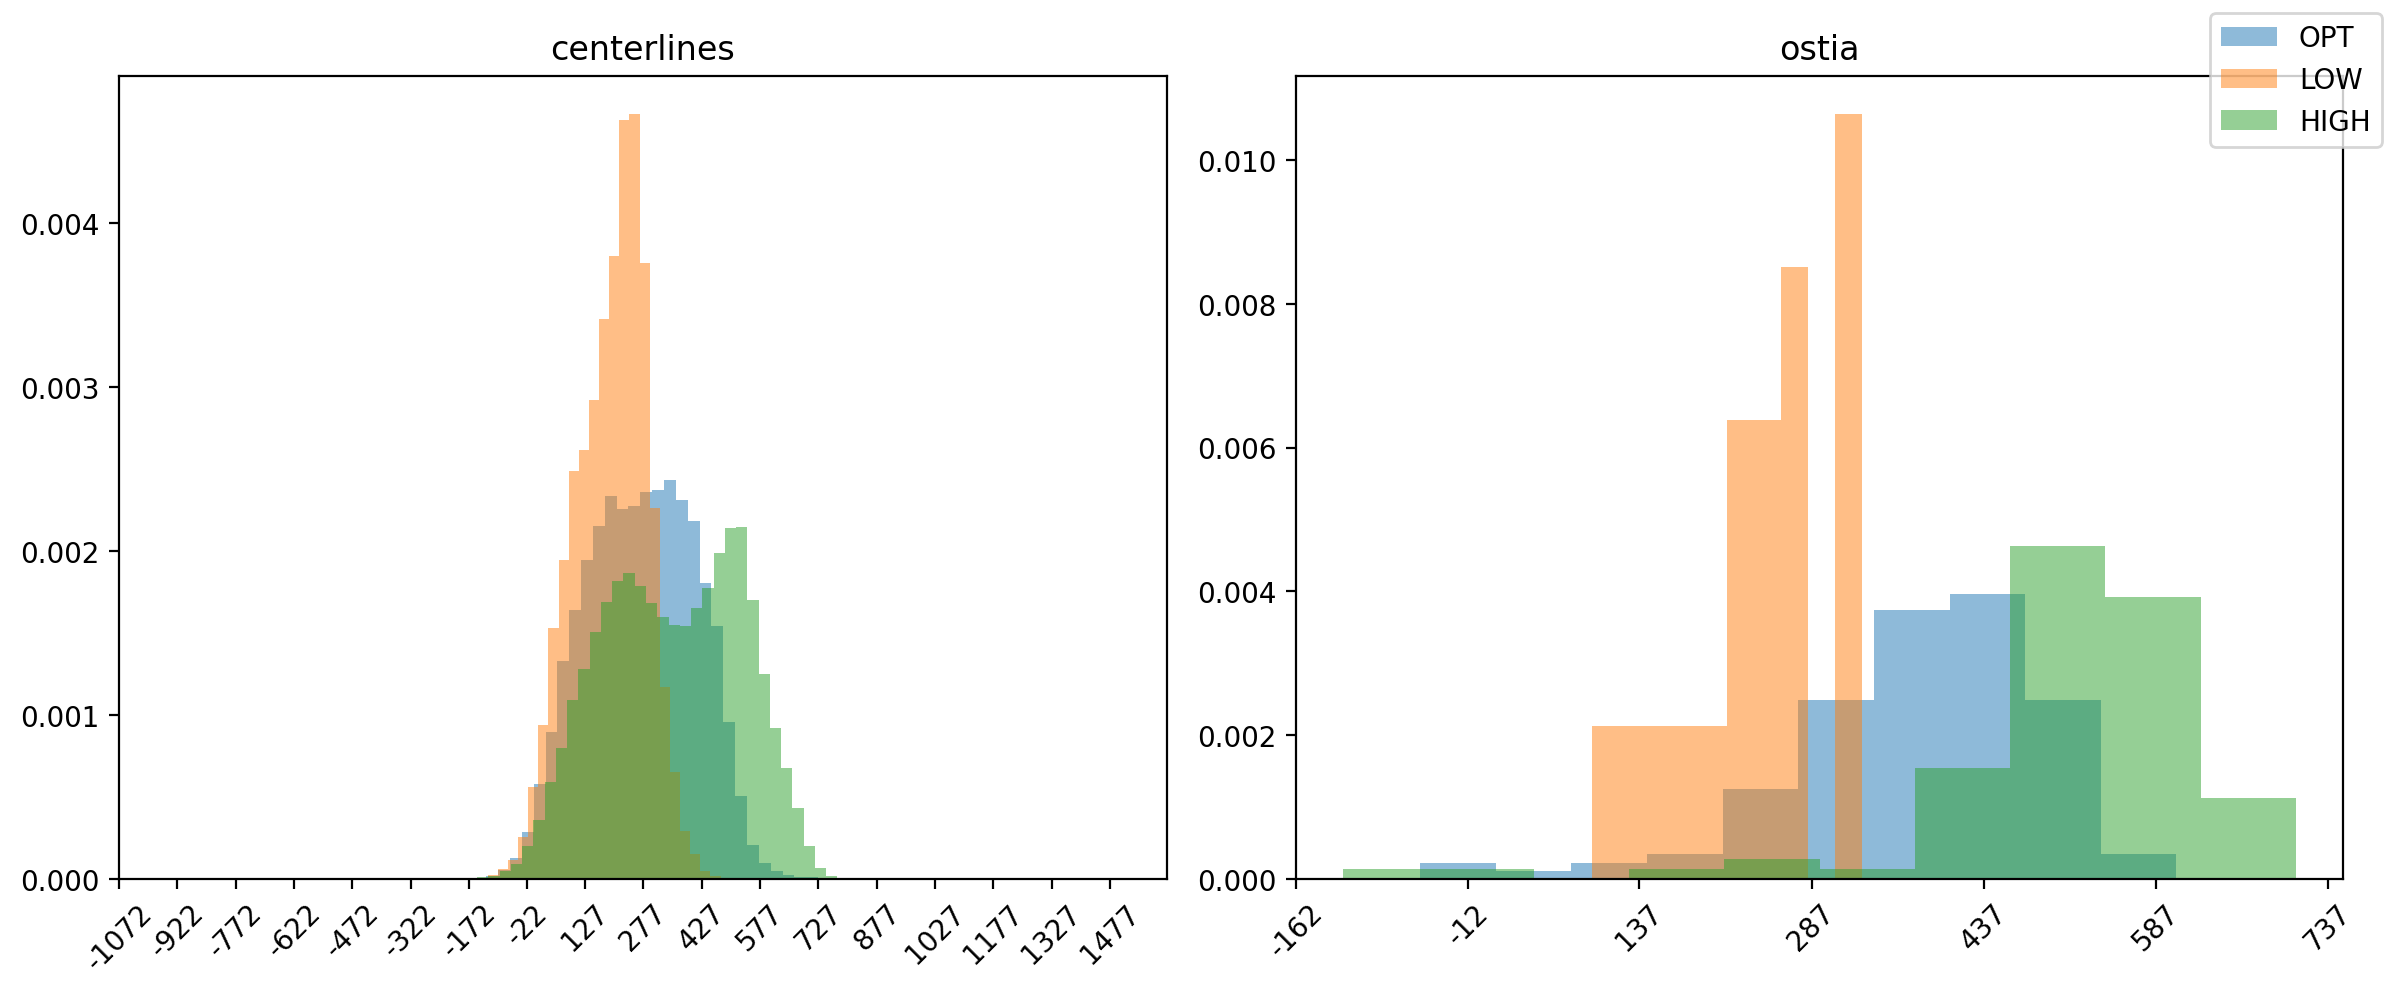

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for tag, ax in zip(["centerlines", "ostia"], axes.flat):
    for st in ScanType:
        values = raw_HU_distributions[st][tag]
        _, bins, *_ = ax.hist(
            values,
            bins=80 if tag == "centerlines" else None,
            label=st.name,
            density=True,
            alpha=0.5,
        )
        print(
            f"{tag} {st} median {np.median(values).astype(int)} mean {np.mean(values).astype(int)} bounds {values.min()} {values.max()}"
        )
    print()
    xticks = np.arange(*ax.get_xlim(), 150).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)
    ax.set_title(tag)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)

--- 

### 2.4 Create cross-validation splits

In [ ]:
N_FOLDS = 3

train_splits, val_splits = data_u.cross_val_splits(
    N_FOLDS, FINAL_DF_FNAME, seed=DEFAULT_SEED
)

# show some information like raw number of scans in each split
for cval in [train_splits, val_splits]:
    print("-------")
    for split in cval:
        df =pd.DataFrame(split, columns=["path", "label"])
        counts =df.groupby("label").count()
        display(counts)
        print((counts / len(df)).values)

-------


,path
label,
-1,7
0,44
1,29


[[0.0875]
 [0.55  ]
 [0.3625]]


,path
label,
-1,7
0,45
1,28


[[0.0875]
 [0.5625]
 [0.35  ]]


,path
label,
-1,6
0,45
1,29


[[0.075 ]
 [0.5625]
 [0.3625]]
-------


,path
label,
-1,3
0,23
1,14


[[0.075]
 [0.575]
 [0.35 ]]


,path
label,
-1,3
0,22
1,15


[[0.075]
 [0.55 ]
 [0.375]]


,path
label,
-1,4
0,22
1,14


[[0.1 ]
 [0.55]
 [0.35]]


In [ ]:
CVAL_OUT_FILE = ROOT_DIR / "cross_val_splits.pkl"

if not CVAL_OUT_FILE.is_file():
    write_pickle({"train": train_splits, "test": val_splits}, CVAL_OUT_FILE)
    print(f"Wrote {str(CVAL_OUT_FILE)!r}")